## Project: Toxic Comment Filter

Build a model that can filter user comments according to the degree of harmfulness of the language:
1. Preprocess the text by eliminating the set of tokens that do not make significant contribution at the semantic level
2. Transform the text corpus into sequences
3. Build a Deep Learning model including recurrent layers for a multilabel classification task
4. At prediction time, the model must return a vector containing a 1 or a 0 at each label in the dataset (toxic, severe_toxic, obscene, threat, insult, identity_hate). In this way, a non-harmful comment will be classified by a vector of only 0s [0,0,0,0,0]. In contrast, a dangerous comment will exhibit at least a 1 among the 6 labels.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
BASE_URL = "https://s3.eu-west-3.amazonaws.com/profession.ai/datasets/"
df = pd.read_csv(BASE_URL+"Filter_Toxic_Comments_dataset.csv")

#### Utils

In [ ]:
import warnings
warnings.filterwarnings("ignore")

from google.colab import drive
drive.mount('/content/drive')

import shutil


Mounted at /content/drive


In [ ]:
LABELS = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult','identity_hate']

# EDA
I exctract some information about the different toxic comment and plot the distribuition of the dataset

In [ ]:
def plot_negative_comments(df, columns):
  palette = sns.color_palette('Dark2')
  ax = sns.barplot(x=df[col].value_counts().index,
            y=df[col].value_counts().values,
            palette=palette)
  for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2., p.get_height(), '%d' % int(p.get_height()),
                fontsize=10, color='black', ha='center', va='bottom',rotation=45)

  plt.show()

In [ ]:
print(f'The dataframe has {len(df)} entries')
print('-'*120)
df.head()
print('-'*120)
df.info()

The dataframe has 159571 entries
------------------------------------------------------------------------------------------------------------------------


,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum_injurious
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0


------------------------------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   comment_text   159571 non-null  object
 1   toxic          159571 non-null  int64 
 2   severe_toxic   159571 non-null  int64 
 3   obscene        159571 non-null  int64 
 4   threat         159571 non-null  int64 
 5   insult         159571 non-null  int64 
 6   identity_hate  159571 non-null  int64 
 7   sum_injurious  159571 non-null  int64 
dtypes: int64(7), object(1)
memory usage: 9.7+ MB


<Axes: ylabel='Count'>

Text(0.5, 0, 'Length of comments')

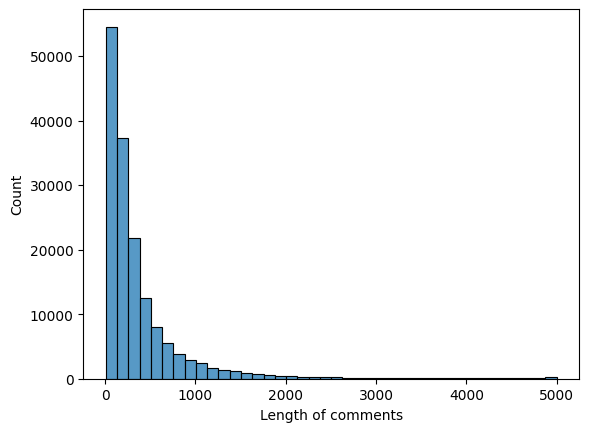

In [ ]:
sentence_lengths = [len(sentence) for sentence in df["comment_text"]]
sns.histplot(sentence_lengths,
             bins=40,
             palette=sns.color_palette('Dark2'))

plt.xlabel('Length of comments')
plt.show()

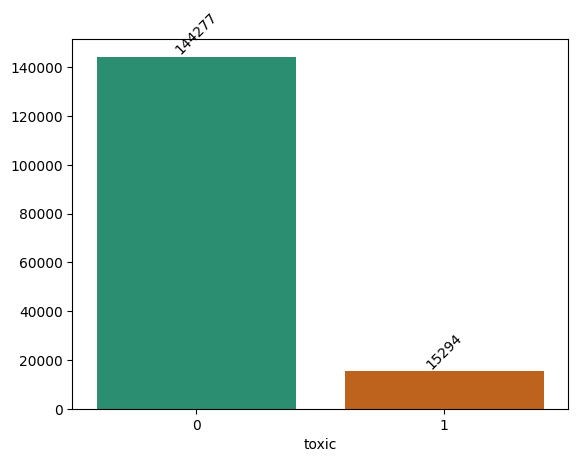

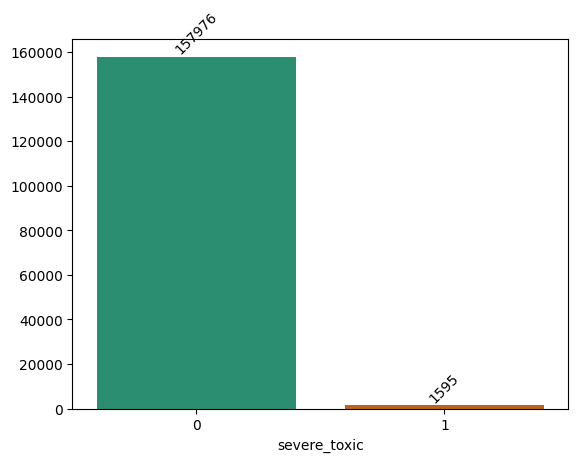

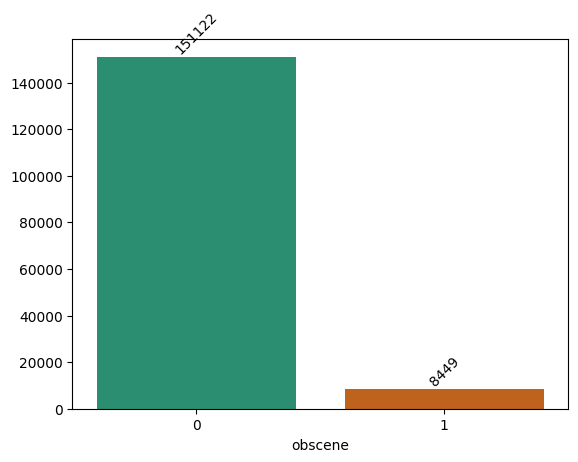

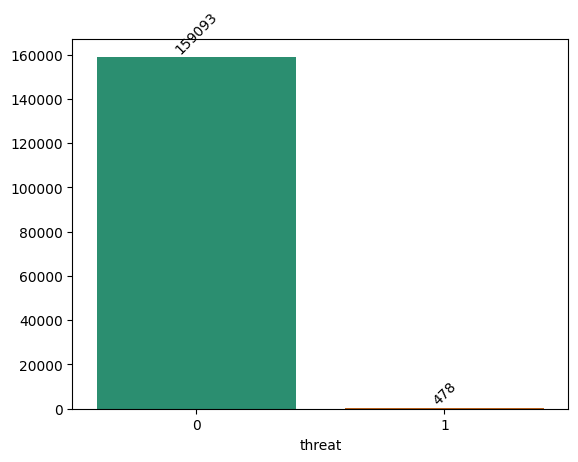

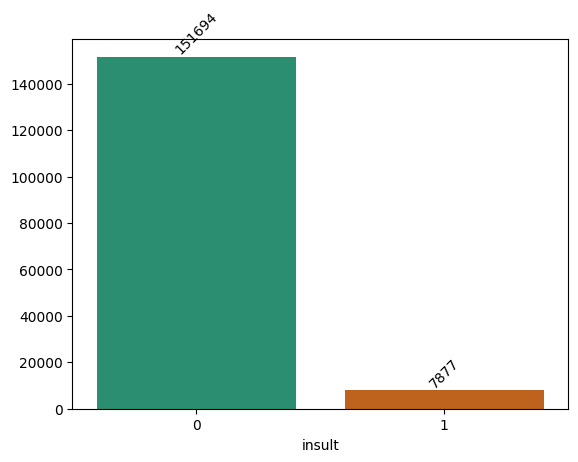

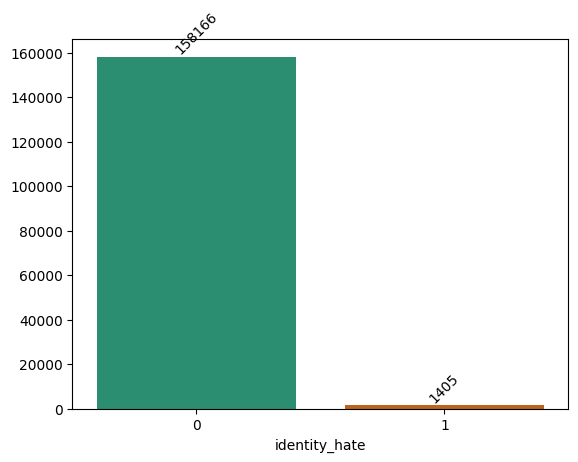

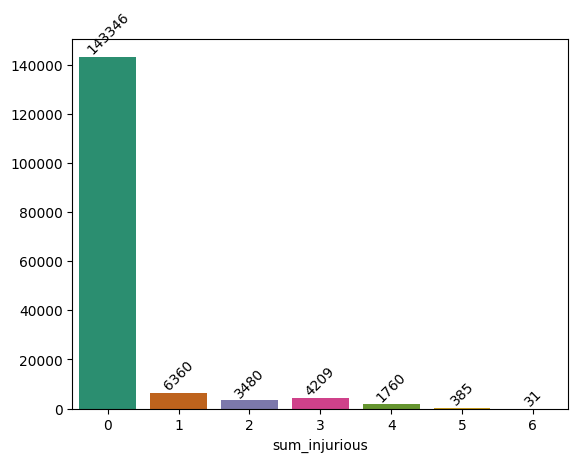

In [ ]:
# I plot labels distributions
# I can see that "negative comments" are a lot undersampled in this dataset
for col in df.columns:
  if col != 'comment_text':
    plot_negative_comments(df, col)

([<matplotlib.patches.Wedge at 0x7a909804a6b0>,
 [Text(-1.0443318417536962, 0.3455010916036777, 'Non-Toxic'),
  Text(1.0443318336666592, -0.34550111604802886, 'Toxic')],
 [Text(-0.5696355500474706, 0.18845514087473328, '89.8%'),
  Text(0.5696355456363594, -0.1884551542080157, '10.2%')])

(-1.0999999901672077,
 1.0999999995317717,
 -1.0999997955585146,
 1.0999997494319025)

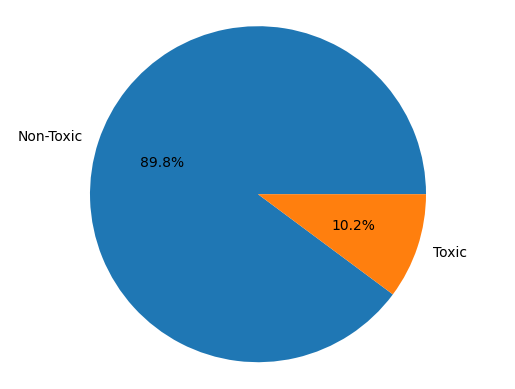

In [ ]:
# I plot a pie chart to show the relative distribution of "negative comments"
relative_non_toxic = round((len(df[df['sum_injurious']==0])/len(df))*100,2)
relative_toxic = round((len(df[df['sum_injurious']!=0])/len(df))*100,2)

labels = 'Non-Toxic', 'Toxic'
sizes = [relative_non_toxic, relative_toxic]
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.axis('equal')
plt.show()

#### Comment
As I can see, the df is undersampled for negative comment. After when I create y_train and y_test Ill've save the inverse frequencies of labels to train the "base model" and the NN with argument "class_weight".


In [ ]:
# Calculate class distribution
class_distribution = np.sum(df[LABELS], axis=0) / len(df)

# Compute inverse class weights
inverse_class_weights = {i: 1.0 / class_distribution[i] for i in range(len(class_distribution))}
inverse_class_weights

{0: 10.433568719759382,
 1: 100.04451410658307,
 2: 18.886377086045687,
 3: 333.8305439330544,
 4: 20.257839278913295,
 5: 113.57366548042704}

# Data cleaning
In the samples of the series 'comment_text' there are a lot of characters which are not important for the model analysis, so I made a cleaning fuctions for the dataset (I could have done it all in one function, however for educational purposes I preferred to visualize each step)

In [ ]:
from collections import Counter
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')



def count_different_words(df):
  word_cnt = Counter()
  for words in df.values:
    for word in words.split():
      word_cnt[word] +=1
  return word_cnt


def lowering_text(comment):
  return comment.str.lower()

def removing_punctuations(comment):
  return comment.str.replace('[^\w\s]',' ', regex=True)

def removing_urls(comment):
  url_pattern = re.compile(r'https?://\S+|www\.\S+')
  no_url = url_pattern.sub(r'', comment)
  return no_url

def removing_digits(comment):
    comment = comment.str.replace('\d+', '', regex=True)
    return comment

def removing_special_char(comment):
  char = ["\n", "\t", "/", "\\"]
  for i in char:
    comment = comment.str.replace(i, '')
  return comment

def removing_stopwords(comment):
  STOP_WORDS = set(stopwords.words('english'))
  return ' '.join([word for word in str(comment).split() if len(word)>1 and word not in STOP_WORDS])

def stem_and_lemmatize(comment):
  stemmer = SnowballStemmer('english')
  lemmatizer = WordNetLemmatizer()
  words = word_tokenize(comment)
  stem_and_lem = [lemmatizer.lemmatize(stemmer.stem(w)) for w in words]
  return ' '.join(stem_and_lem)


def removing_whithe_spaces(comment):
  return re.sub(r'\s+', ' ', comment)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
def contains_non_latin_characters(text):
    return bool(re.search('[^\u0000-\u007F]', text))

def removing_non_latin(df, column_name):
    non_latin_comments = []

    # Iterate over the comments and check for non-Latin characters
    for comment in df[column_name]:
        if contains_non_latin_characters(comment):
            non_latin_comments.append(comment)

    # Create a DataFrame for non-Latin comments
    non_latin_df = pd.DataFrame(non_latin_comments, columns=[column_name])

    # Remove rows with non-Latin comments from the original DataFrame
    df = df[~df[column_name].apply(contains_non_latin_characters)]

    return df, non_latin_df

def not_latin_characters(df):
  """
  this fuction saves foreign characters
  input -> df with not latin comments
  output -> foreign_characters, i.e. a list of words from 'not_latin' that contain non-Latin characters.
  """
  foreign_characters = []

  for comment in df.values:
    words = str(comment).split()
    for word in words:
      if word.isascii() == False:
        foreign_characters.append(word)
  return foreign_characters

In [ ]:
#lowering comments
df['clean_comment'] = lowering_text(df['comment_text'])
df[['comment_text', 'clean_comment']].sample(5)

,comment_text,clean_comment
59663,"""\nAlso, I'm not concerned about a block from ...","""\nalso, i'm not concerned about a block from ..."
46545,"""\n\n I created a sock puppet for use with my ...","""\n\n i created a sock puppet for use with my ..."
71823,Kosovo Serbs \nIt would be foolish to claim ...,kosovo serbs \nit would be foolish to claim ...
111654,""" A new commtrcial concern.\nWhich will serve ...",""" a new commtrcial concern.\nwhich will serve ..."
111724,Image source problem with Image:Pt plelection ...,image source problem with image:pt plelection ...


In [ ]:
#removing punctuations
df['clean_comment'] = removing_punctuations(df['clean_comment'])
df[['comment_text', 'clean_comment']].sample(5)

,comment_text,clean_comment
110320,""" in the mind."""" It originally comes from the ...",in the mind it originally comes from the ...
154005,But then I rarely get my evil way with anythin...,but then i rarely get my evil way with anythin...
155507,I see the argument of both. Since there is a ...,i see the argument of both since there is a ...
62280,"""\n\nNot only is """"Tees Valley"""" a made-up nam...",\n\nnot only is tees valley a made up nam...
72473,"No worries, Anowlin,\n\nNow that I know it was...",no worries anowlin \n\nnow that i know it was...


In [ ]:
# removing urls from comments
df['clean_comment'] = df['clean_comment'].apply(lambda x: removing_urls(x))
df[['comment_text', 'clean_comment']].sample(5)

,comment_text,clean_comment
152424,""", 22 September 2005 (UTC)\n\n""""""""""""You shall ...",22 september 2005 utc \n\n you shall ...
146691,"""\nIf they are done by hand, wouldn't it be ea...",\nif they are done by hand wouldn t it be ea...
2080,I agree. Without more information about jinfo...,i agree without more information about jinfo...
98290,See also\n\nOther time-frequency transforms:\n...,see also\n\nother time frequency transforms \n...
120523,please refrain from such childish behaviour as...,please refrain from such childish behaviour as...


In [ ]:
# removing numbers from comments
df['clean_comment'] = removing_digits(df['clean_comment'])
df[['comment_text', 'clean_comment']].sample(5)

,comment_text,clean_comment
1869,"2014 (UTC)\n\nI agree with deletion. 13:57, ...",utc \n\ni agree with deletion october
93479,"""\nGTBacchus, that is an excellent idea. Indee...",\ngtbacchus that is an excellent idea indee...
23228,Sianna Rennocks \n\n Biography \nBorn Sianna M...,sianna rennocks \n\n biography \nborn sianna m...
91687,"""\n\n Please do not vandalize pages, as you di...",\n\n please do not vandalize pages as you di...
121183,"You definately are friendly, which is a good t...",you definately are friendly which is a good t...


In [ ]:
# removing special characters from comments
df['clean_comment'] = removing_special_char(df['clean_comment'])
df[['comment_text', 'clean_comment']].sample(5)

,comment_text,clean_comment
66891,"""\n That would be best, if available. Still, ""...",that would be best if available still d...
21642,Redirecting to Halo (series)#Other games per n...,redirecting to halo series other games per n...
48489,"Yes, I believe it is. Thank you very much.",yes i believe it is thank you very much
34906,But consider the actual meaning of that - an e...,but consider the actual meaning of that an e...
26077,"If your reason for denial is not true, wouldn'...",if your reason for denial is not true wouldn ...


In [ ]:
# removing english stopwords
df['clean_comment'] = df['clean_comment'].apply(lambda x: removing_stopwords(x))
df[['comment_text', 'clean_comment']].sample(5)

,comment_text,clean_comment
107518,While I strongly encourage you to avoid revert...,strongly encourage avoid reverting article how...
139756,"""::::::: So much for the """"user-written encycl...",much user written encyclopedia much consensus ...
59466,ANI notice \n\nWikipedia:Administrators' notic...,ani notice wikipedia administrators noticeboar...
8418,"""\n\n Request \n\nChimp, can you do me a favor...",request chimp favor please saw produced someon...
58677,"(NH4)2Ce(SO4)3 redirects here, it is also a va...",nh ce redirects also vary safe oxidizer electr...


In [ ]:
#remove white spaces created after cleaning dataset
df['clean_comment'] = df['clean_comment'].apply(lambda x: removing_whithe_spaces(x))
df[['comment_text', 'clean_comment']].sample(5)

,comment_text,clean_comment
634,season 5 issues\nNot sure why you removed my e...,season issuesnot sure removed edits season fut...
151280,Regarding ads: There a dozens of good game-jou...,regarding ads dozens good game journalism sour...
26929,"Hi Mihir,\n\nIf you are visiting again this pa...",hi mihir visiting page vandalise periyar pages...
78332,you need add characters like Sai Hinoki,need add characters like sai hinoki
128046,"Pardon me, but it appears your dog Schmuckola ...",pardon appears dog schmuckola nipping heels pl...


In [ ]:
#remove non-latin comments
df, non_latin_comments_df = removing_non_latin(df, 'clean_comment')

#save foreign characters and display some of them
foreign_characters = not_latin_characters(non_latin_comments_df)
print(f'There are {len(foreign_characters)} foreign characters in the dataframe and this are some exaples: \n{foreign_characters[11:100:10]}')

There are 9365 foreign characters in the dataframe and this are some exaples: 
['kymantaitė', 'país', 'kraljević', 'meštrović', 'junačke', '御法度', 'αἰτίας', "琉竜']", 'קו']


In [ ]:
# stemming and lemmination
df['clean_comment'] = df['clean_comment'].apply(lambda x: stem_and_lemmatize(x))
df[['comment_text', 'clean_comment']].sample(5)

,comment_text,clean_comment
135390,Inappropriate blocking \n\nTo return from self...,inappropri block return self impos semi retir ...
14593,"""\noops. i was misnavigating the edit history ...",oop misnavig edit histori accident reinstat so...
56301,The Grassington and Starbotton EL commercial l...,grassington starbotton el commerci link delet
1044,Very Nice Work with Aristotle Onassis \n\nNice...,nice work aristotl onassi nice meet nice work ...
27100,"""\nI have been silent too long myself. I have ...",silent long watch articl deterior must agre jo...


In [ ]:
# print some examples
df[['comment_text', 'clean_comment']].sample(10)

,comment_text,clean_comment
95137,Feel free to read an article in Wikipedia abou...,feel free read articl wikipedia parti know say
261,"""#if:|== ==|}}\n{| width=""""100%"""" style=""""bac...",width style background transpar width style ba...
131333,'Alo \n\nCould you please unprotect my talk pa...,alo could plea unprotect talk page
122333,"""\n\nI don't know what happened with the above...",know happen mess fix punk
51239,And what action did you take against the idiot...,action take idiot keep revert product edit abs...
30333,Interesting Reading\nA Criticism of the Wikipe...,interest readinga critic wikipediawikipedia re...
67791,""":That is not good enough - as per WP guidelin...",good enough per wp guidelin encycloped content...
65956,I only put in an image of the virus on the rig...,put imag virus right sinc much whitespac
3242,"""\n\nThanks. That's three of us now, and coun...",thank three u count abus anyth common legitim ...
95110,"edit war is justified, talk page not consensus...",edit war justifi talk page consensus page bias...


<Axes: ylabel='Count'>

Text(0.5, 0, 'Length of comments')

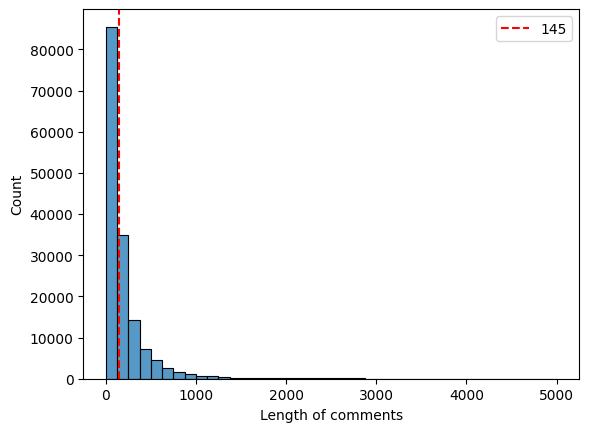

In [ ]:
# save 60% of sentecence lengh for tokenination
sentence_lengths = [len(sentence) for sentence in df["clean_comment"]]
MAX_LEN = int(np.percentile(sentence_lengths,60))
sns.histplot(sentence_lengths,
             bins=40,
             palette=sns.color_palette('Dark2'))
plt.axvline(MAX_LEN, color='red', linestyle='--',label=MAX_LEN)

plt.legend()
plt.xlabel('Length of comments')
plt.show()

# MODELS

In [ ]:
!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 8.1 MB/s eta 0:00:00


In [ ]:
import random
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import make_pipeline
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.backend import clear_session
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout, Bidirectional
from keras.metrics import TruePositives, FalsePositives
from keras.metrics import Precision, Recall, F1Score
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
import tensorflow_addons as tfa
RANDOM_SEED = 97

## Base Model
I create a "base model" with a Multioutput Classifier in sklern with a Logistic Regression to have baseline metrics for comparison with LSTM model

In [ ]:
x = df['clean_comment'].values
y = df.drop(['comment_text', 'clean_comment','sum_injurious'], axis=1).values

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.3, random_state=RANDOM_SEED)

In [ ]:
multi_log_reg = make_pipeline(
    CountVectorizer(max_features=MAX_LEN),
    MultiOutputClassifier(LogisticRegression(class_weight=inverse_class_weights))
)

In [ ]:
multi_log_reg.fit(x_train, y_train)

Pipeline(steps=[('countvectorizer', CountVectorizer(max_features=145)),
                ('multioutputclassifier',
                 MultiOutputClassifier(estimator=LogisticRegression(class_weight={0: 10.433568719759382,
                                                                                  1: 100.04451410658307,
                                                                                  2: 18.886377086045687,
                                                                                  3: 333.8305439330544,
                                                                                  4: 20.257839278913295,
                                                                                  5: 113.57366548042704})))])

In [ ]:
print(classification_report(y_train, multi_log_reg.predict(x_train), target_names=LABELS))
print('='*60)
print(classification_report(y_test, multi_log_reg.predict(x_test), target_names=LABELS))

               precision    recall  f1-score   support

        toxic       0.23      0.82      0.36     10675
 severe_toxic       0.33      0.55      0.41      1079
      obscene       0.48      0.51      0.49      5899
       threat       0.14      0.07      0.10       327
       insult       0.34      0.49      0.40      5528
identity_hate       0.11      0.03      0.04       995

    micro avg       0.28      0.62      0.38     24503
    macro avg       0.27      0.41      0.30     24503
 weighted avg       0.31      0.62      0.39     24503
  samples avg       0.07      0.06      0.06     24503

               precision    recall  f1-score   support

        toxic       0.23      0.82      0.36      4515
 severe_toxic       0.37      0.52      0.43       508
      obscene       0.47      0.51      0.49      2499
       threat       0.07      0.04      0.05       141
       insult       0.33      0.49      0.39      2306
identity_hate       0.06      0.02      0.03       398

    m

In [ ]:
# predcitions for model evaluations
basemodel_y_pred_train = multi_log_reg.predict(x_train)
basemodel_y_pred_test = multi_log_reg.predict(x_test)


#### Comment
The 'base model' have less f1 score especially on 'threat' and 'identity_hate'; in fact the average weighted f1score in less than 0.5

## Tokenizer and pre-training



In [ ]:
# Hyperparameter of number of words
NUMBER_OF_WORDS = 100000

In [ ]:
corpus = df['clean_comment'].values
tokenizer = Tokenizer(num_words=NUMBER_OF_WORDS)
tokenizer.fit_on_texts(corpus)
vocabulary_size= len(tokenizer.word_index)+1
sequences = tokenizer.texts_to_sequences(corpus)

padded_seq = pad_sequences(sequences, maxlen=MAX_LEN, padding= 'post', truncating='post')
print(padded_seq)

[[61683     4    69 ...     0     0     0]
 [11120   891   454 ...     0     0     0]
 [  339   329    74 ...     0     0     0]
 ...
 [20264  5062  3641 ...     0     0     0]
 [   35     7    96 ...     0     0     0]
 [   74    15   139 ...     0     0     0]]


In [ ]:
vocabulary_size

140990

In [ ]:
# Reverse the tokenization
index_to_word = dict(map(reversed, tokenizer.word_index.items()))

# Function to convert sequences back to text
def sequences_to_text(sequences):
    return ' '.join(index_to_word[i] for i in sequences if i != 0)

In [ ]:
x = padded_seq

x.shape
y.shape

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=.2, random_state=RANDOM_SEED)

(156096, 145)

(156096, 6)

In [ ]:
#reverse the tokenination one example of x_train and x_test
sequences_to_text(x_train[121])
y_train[121]
print('='*100)
sequences_to_text(x_test[897])
y_test[897]

'adopt hi kati also interest adopt member long time edit mani page german french english rd generat american decend austrian german heritag still interest adopt would love help'

array([0, 0, 0, 0, 0, 0])

'major fag go write paragraph fag never contact dear gb fag whoop fag tri get man hope also act dooshish way dont like play prank dooshish websit last contact say mean thing never bother bye gb fag hope forev'

array([1, 0, 0, 0, 1, 0])

## Imbalanced model
I start with training of the imbalaced model.
Since the model is unbalanced I decide to analyse F1Score as metrics instead of accuracy.
I implement an early stopping with the F1 Score, because I want a tradeoff between precision and recall and stop the training when it can’t be improved

In [ ]:
def plot_learning_curve(model_hist):
  """
  this futction plot differents number of subplots based on metrics choosen during fit
  input -> model.history
  output -> subplots of learning curve for different metrics
  """
  key_dict = list(model_hist.keys())
  n = len(key_dict) // 2  # Number of subplots

  # Calculate number of rows and columns for subplots
  nrows = int(np.ceil(np.sqrt(n)))
  ncols = int(np.ceil(n / nrows))

  fig, axes = plt.subplots(nrows, ncols)

  # Flatten the axes array for easy iteration
  axes_flat = axes.flatten()

  # Loop through the keys for plotting
  for i in range(n):
      ax = axes_flat[i]
      ax.plot(model_hist[key_dict[i]], label=key_dict[i])
      ax.plot(model_hist[key_dict[i+n]], label=key_dict[i+n])
      ax.legend()

  # Remove extra subplots
  for i in range(n, nrows*ncols):
      fig.delaxes(axes_flat[i])

  plt.tight_layout()
  return plt.show()


### Model 1

In [ ]:
# Calculate class distribution
class_distribution = np.sum(y_train, axis=0) / len(y_train)

# Compute inverse class weights
inverse_class_weights = {i: 1.0 / class_distribution[i] for i in range(len(class_distribution))}
inverse_class_weights

{0: 10.24665627307787,
 1: 99.42356687898089,
 2: 18.54135115070527,
 3: 342.12602739726026,
 4: 19.932322426177176,
 5: 112.19766397124889}

In [ ]:
# I decide to the 10k most frequents words istead of all vocabulary size
INPUT_SIZE = 10000

In [ ]:
clear_session()
simple_model = Sequential()
simple_model.add(Embedding(INPUT_SIZE, 50, input_length=MAX_LEN))
simple_model.add(Bidirectional(LSTM(32, activation = "tanh")))
simple_model.add(Dense(128, activation = 'relu'))
simple_model.add(Dense(6,  activation = "sigmoid"))
simple_model.summary()

es = EarlyStopping('val_f1_score', patience= 60, verbose = 1, mode='max', restore_best_weights=True)

simple_model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics =[tfa.metrics.F1Score(num_classes=6, average = 'weighted')])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 145, 50)           500000    
                                                                 
 bidirectional (Bidirection  (None, 64)                21248     
 al)                                                             
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 6)                 774       
                                                                 
Total params: 530342 (2.02 MB)
Trainable params: 530342 (2.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history1 = simple_model.fit(x_train, y_train, validation_split=.2,
                            epochs=400, batch_size=128, callbacks = [es], class_weight= inverse_class_weights)

Epoch 1/400
781/781 [==============================] - 103s 117ms/step - loss: 1.0295 - f1_score: 0.0977 - val_loss: 0.0547 - val_f1_score: 0.0781
Epoch 2/400
781/781 [==============================] - 30s 38ms/step - loss: 0.6168 - f1_score: 0.0894 - val_loss: 0.0550 - val_f1_score: 0.1996
Epoch 3/400
781/781 [==============================] - 21s 27ms/step - loss: 0.5717 - f1_score: 0.0830 - val_loss: 0.0540 - val_f1_score: 0.0781
Epoch 4/400
781/781 [==============================] - 19s 24ms/step - loss: 0.5242 - f1_score: 0.0787 - val_loss: 0.0540 - val_f1_score: 0.0781
Epoch 5/400
781/781 [==============================] - 16s 20ms/step - loss: 0.4688 - f1_score: 0.0812 - val_loss: 0.0568 - val_f1_score: 0.0786
Epoch 6/400
781/781 [==============================] - 15s 20ms/step - loss: 0.4238 - f1_score: 0.0919 - val_loss: 0.0605 - val_f1_score: 0.0908
Epoch 7/400
781/781 [==============================] - 15s 19ms/step - loss: 0.3887 - f1_score: 0.1060 - val_loss: 0.0641 - val_

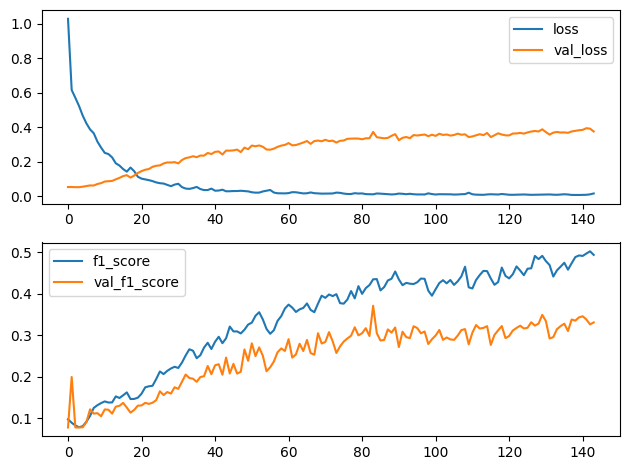

3903/3903 [==============================] - 23s 6ms/step
               precision    recall  f1-score   support

        toxic       0.96      0.91      0.93     12187
 severe_toxic       0.84      0.87      0.86      1256
      obscene       0.96      0.93      0.94      6735
       threat       0.83      0.80      0.82       365
       insult       0.93      0.90      0.92      6265
identity_hate       0.89      0.85      0.87      1113

    micro avg       0.94      0.91      0.92     27921
    macro avg       0.90      0.88      0.89     27921
 weighted avg       0.94      0.91      0.92     27921
  samples avg       0.09      0.09      0.09     27921

976/976 [==============================] - 5s 5ms/step
               precision    recall  f1-score   support

        toxic       0.78      0.66      0.72      3003
 severe_toxic       0.34      0.34      0.34       331
      obscene       0.78      0.71      0.75      1663
       threat       0.28      0.28      0.28       103
   

In [ ]:
plot_learning_curve(history1.history)
y_pred_train = simple_model.predict(x_train).round()
print(classification_report(y_train, y_pred_train, target_names = LABELS))
print('='*60)
y_pred_test = simple_model.predict(x_test).round()
print(classification_report(y_test, y_pred_test, target_names = LABELS))

In [ ]:
# save the model
simple_model.save('simple.keras')
shutil.copy("/content/simple.keras","/content/drive/MyDrive/Colab Notebooks")

'/content/drive/MyDrive/Colab Notebooks/simple.keras'

#### Comment  
With LSTM metrics are better in general -> 0.64 weighted F1 score in test_set.
However the model has low f1_score on "severe_toxic, threat and identity_hate".
Fist think I can notice is overfittng: the loss in the train model is shrinking, but not in the validation set. I implement a more simple model and some tecnique as L2 regolarization anmd Dropout to try to solve overfitting


### Model 2

In [ ]:
l2_reg = 0.01  # Regularization strength


clear_session()
simple_model2 = Sequential()
simple_model2.add(Embedding(INPUT_SIZE, 250, input_length=MAX_LEN))
simple_model2.add(Bidirectional(LSTM(32, activation = "tanh", kernel_regularizer=l2(l2_reg))))
simple_model2.add(Dropout(0.2))
simple_model2.add(Dense(128, activation = 'relu'))
simple_model2.add(Dense(6,  activation = "sigmoid"))
simple_model2.summary()

es = EarlyStopping('val_f1_score', patience= 60, verbose = 1, mode='max', restore_best_weights=True)

simple_model2.compile(optimizer='adam', loss='binary_crossentropy',
              metrics =[tfa.metrics.F1Score(num_classes=6, average = 'weighted')])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 145, 250)          2500000   
                                                                 
 bidirectional (Bidirection  (None, 64)                72448     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 6)                 774       
                                                                 
Total params: 2581542 (9.85 MB)
Trainable params: 2581542 (9.85 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [ ]:
history2 = simple_model2.fit(x_train, y_train, validation_split=.2,
                            epochs=400, batch_size=64, callbacks = [es], class_weight= inverse_class_weights)

Epoch 1/400
1561/1561 [==============================] - 112s 67ms/step - loss: 1.0218 - f1_score: 0.0854 - val_loss: 0.0849 - val_f1_score: 0.0781
Epoch 2/400
1561/1561 [==============================] - 38s 25ms/step - loss: 0.6632 - f1_score: 0.0793 - val_loss: 0.0849 - val_f1_score: 0.0781
Epoch 3/400
1561/1561 [==============================] - 32s 20ms/step - loss: 0.6379 - f1_score: 0.0775 - val_loss: 0.0699 - val_f1_score: 0.0781
Epoch 4/400
1561/1561 [==============================] - 29s 18ms/step - loss: 0.6110 - f1_score: 0.0784 - val_loss: 0.0740 - val_f1_score: 0.0781
Epoch 5/400
1561/1561 [==============================] - 28s 18ms/step - loss: 0.5863 - f1_score: 0.0784 - val_loss: 0.0761 - val_f1_score: 0.0781
Epoch 6/400
1561/1561 [==============================] - 30s 19ms/step - loss: 0.5815 - f1_score: 0.0775 - val_loss: 0.0740 - val_f1_score: 0.0781
Epoch 7/400
1561/1561 [==============================] - 29s 18ms/step - loss: 0.5508 - f1_score: 0.0778 - val_loss: 

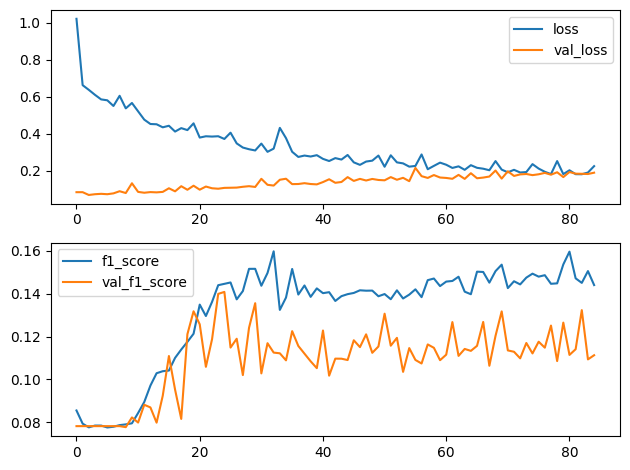

3903/3903 [==============================] - 25s 6ms/step
               precision    recall  f1-score   support

        toxic       0.88      0.87      0.88     12187
 severe_toxic       0.63      0.28      0.38      1256
      obscene       0.91      0.89      0.90      6735
       threat       0.35      0.25      0.29       365
       insult       0.77      0.84      0.81      6265
identity_hate       0.72      0.43      0.54      1113

    micro avg       0.85      0.82      0.83     27921
    macro avg       0.71      0.59      0.63     27921
 weighted avg       0.84      0.82      0.82     27921
  samples avg       0.08      0.08      0.08     27921

976/976 [==============================] - 5s 5ms/step
               precision    recall  f1-score   support

        toxic       0.74      0.72      0.73      3003
 severe_toxic       0.65      0.25      0.36       331
      obscene       0.80      0.77      0.78      1663
       threat       0.15      0.15      0.15       103
   

In [ ]:
plot_learning_curve(history2.history)
y_pred_train = simple_model2.predict(x_train).round()
print(classification_report(y_train, y_pred_train, target_names = LABELS))
print('='*60)
y_pred_test = simple_model2.predict(x_test).round()
print(classification_report(y_test, y_pred_test, target_names = LABELS))

In [ ]:
simple_model2.save('simple2.keras')

In [ ]:
shutil.copy("/content/simple2.keras","/content/drive/MyDrive/Colab Notebooks")

'/content/drive/MyDrive/Colab Notebooks/simple2.keras'

#### Comment
The model seems to be less overfitted.
So now I try to focus on class_weight to penalise more when model mistake to classify label less represented.


## Oversample dataset
Because the dataset is unbalanced I decided to use an oversample script. However SMOTE from imbalanced learn library doesn't work on multy-label classification, so I decided to implement MLSMOTE from this medium link: https://medium.com/thecyphy/handling-data-imbalance-in-multi-label-classification-mlsmote-531155416b87

### How it work MLSMOTE?
- Minority Instance Selection: the first step involves selecting the minority labels that need oversampling. This is done by evaluating the imbalance ratio for each label and the mean imbalance ratio across the dataset. By focusing on the “tail labels,” or those that are least represented, MLSMOTE ensures a more balanced distribution.

- Feature Vector Generation: next, the SMOTE algorithm is applied to generate feature vectors for synthetic data points. This involves creating a new data point by interpolating between a randomly chosen data point and one of its k-nearest neighbors. The goal is to create a diverse set of feature vectors that accurately represent the minority class.

- Label Set Generation: finally, the label set for the new data points is generated. While a simple cloning of the label vector from the reference data point is possible, it ignores the rich information about label correlations. MLSMOTE addresses this by using a ranking approach: it counts the frequency of each label in the reference and neighbor data points, and includes in the synthetic data only those labels that appear with a frequency above a certain threshold. This method leverages label correlation to enhance the quality of the synthetic data. By incorporating these steps, MLSMOTE effectively balances the dataset while preserving the important relationships between labels, leading to more robust multi-label classification models.

In [ ]:
# this is the code from MLSMOTE on https://medium.com/thecyphy/handling-data-imbalance-in-multi-label-classification-mlsmote-531155416b87
# I've done 2 changes:
# 1. I change the last return to have np.arrays instead of pd.DataFrame
# 2. I returned the absolute value of new_X, because the model create negative values which didn't exist in my tokeniker vocabulary

def get_tail_label(df):
    """
    Give tail label colums of the given target dataframe

    args
    df: pandas.DataFrame, target label df whose tail label has to identified

    return
    tail_label: list, a list containing column name of all the tail label
    """
    columns = df.columns
    n = len(columns)
    irpl = np.zeros(n)
    for column in range(n):
        irpl[column] = df[columns[column]].value_counts()[1]
    irpl = max(irpl)/irpl
    mir = np.average(irpl)
    tail_label = []
    for i in range(n):
        if irpl[i] > mir:
            tail_label.append(columns[i])
    return tail_label

def get_index(df):
    """
    give the index of all tail_label rows
    args
    df: pandas.DataFrame, target label df from which index for tail label has to identified

    return
    index: list, a list containing index number of all the tail label
    """
    tail_labels = get_tail_label(df)
    index = set()
    for tail_label in tail_labels:
        sub_index = set(df[df[tail_label]==1].index)
        index = index.union(sub_index)
    return list(index)

def get_minority_instace(X, y):
    """
    Give minority dataframe containing all the tail labels

    args
    X: pandas.DataFrame, the feature vector dataframe
    y: pandas.DataFrame, the target vector dataframe

    return
    X_sub: pandas.DataFrame, the feature vector minority dataframe
    y_sub: pandas.DataFrame, the target vector minority dataframe
    """
    index = get_index(y)
    X_sub = X[X.index.isin(index)].reset_index(drop = True)
    y_sub = y[y.index.isin(index)].reset_index(drop = True)
    return X_sub, y_sub

def nearest_neighbour(X):
    """
    Give index of 5 nearest neighbor of all the instance

    args
    X: np.array, array whose nearest neighbor has to find

    return
    indices: list of list, index of 5 NN of each element in X
    """
    nbs=NearestNeighbors(n_neighbors=5,metric='euclidean',algorithm='kd_tree').fit(X)
    euclidean,indices= nbs.kneighbors(X)
    return indices

def MLSMOTE(X,y, n_sample):
    """
    Give the augmented data using MLSMOTE algorithm

    args
    X: pandas.DataFrame, input vector DataFrame
    y: pandas.DataFrame, feature vector dataframe
    n_sample: int, number of newly generated sample

    return
    new_X: pandas.DataFrame, augmented feature vector data
    target: pandas.DataFrame, augmented target vector data
    """
    indices2 = nearest_neighbour(X)
    n = len(indices2)
    new_X = np.zeros((n_sample, X.shape[1]))
    target = np.zeros((n_sample, y.shape[1]))
    for i in range(n_sample):
        reference = random.randint(0,n-1)
        neighbour = random.choice(indices2[reference,1:])
        all_point = indices2[reference]
        nn_df = y[y.index.isin(all_point)]
        ser = nn_df.sum(axis = 0, skipna = True)
        target[i] = np.array([1 if val>.2 else 0 for val in ser])
        ratio = random.random()
        gap = X.loc[reference,:] - X.loc[neighbour,:]
        new_X[i] = np.array(X.loc[reference,:] + ratio * gap)
        new_X[i] = np.abs(new_X[i]) # I want only positive values for tokens
    new_X = pd.DataFrame(new_X, columns=X.columns)
    target = pd.DataFrame(target, columns=y.columns)
    new_X = pd.concat([X, new_X], axis=0)
    target = pd.concat([y, target], axis=0)
    return new_X.values.astype(int), target.values.astype(int)

In [ ]:
# I create a little fuction to show the distribution of each class of labels
def plot_class_distribution(y):
    sum_y = []
    for i in range(len(y)):
        sum_y.append(np.sum(y[i]))
    no_toxic = Counter(sum_y)[0]
    counts = np.sum(y, axis=0)
    values = [no_toxic]
    print(f'class=0, n={no_toxic}')
    for i,c in enumerate(counts):
        values.append(c)
        print(f'class={i+1}, n={c}')
    plt.bar(range(len(values)), values)
    plt.xticks(np.arange(0,7),['non_toxic','toxic', 'severe_toxic', 'obscene', 'threat', 'insult','identity_hate'],rotation=90)
    plt.xlabel('Class')
    plt.ylabel('n. of comments')
    plt.title('Distribution of Classes')
    plt.show()

class=0, n=111961
class=1, n=12187
class=2, n=1256
class=3, n=6735
class=4, n=365
class=5, n=6265
class=6, n=1113


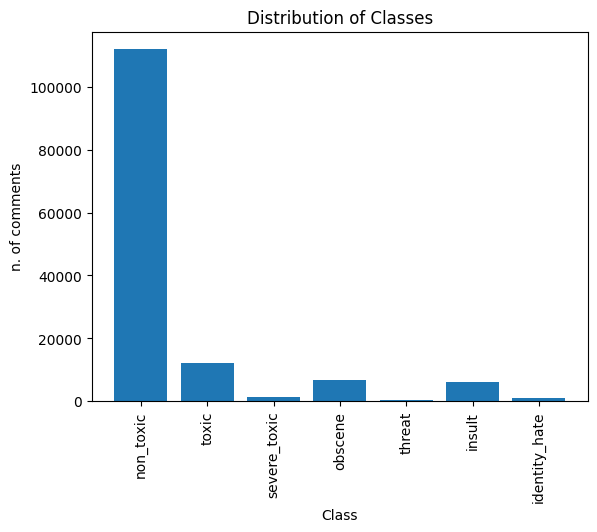

class=0, n=28025
class=1, n=3003
class=2, n=331
class=3, n=1663
class=4, n=103
class=5, n=1569
class=6, n=280


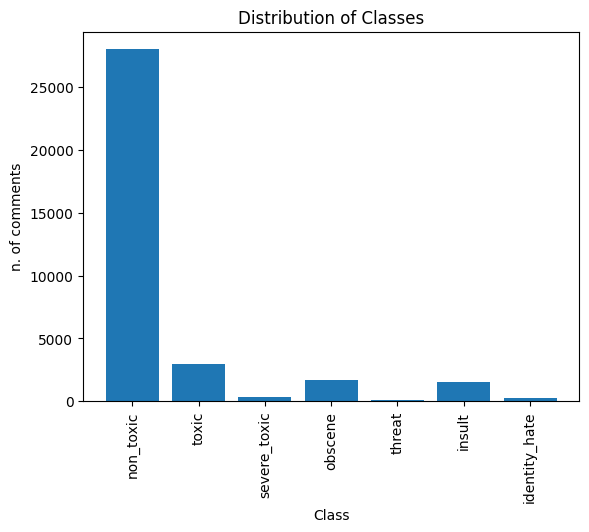

In [ ]:
# I plot distribution for x_train and y_train
plot_class_distribution(y_train)
print('='*80)
plot_class_distribution(y_test)

In [ ]:
# for the MLSMOTE I have to use pd.DataFrame instead of numpy.array
y_train_df = pd.DataFrame(y_train)
x_train_df = pd.DataFrame(x_train)

In [ ]:
x_sub, y_sub = get_minority_instace(x_train_df, y_train_df)
x_res,y_res = MLSMOTE(x_sub, y_sub, int(len(x_train)*.8))

(101297, 145)

(101297, 6)

class=0, n=0
class=1, n=101195
class=2, n=75060
class=3, n=100733
class=4, n=76751
class=5, n=100912
class=6, n=100951


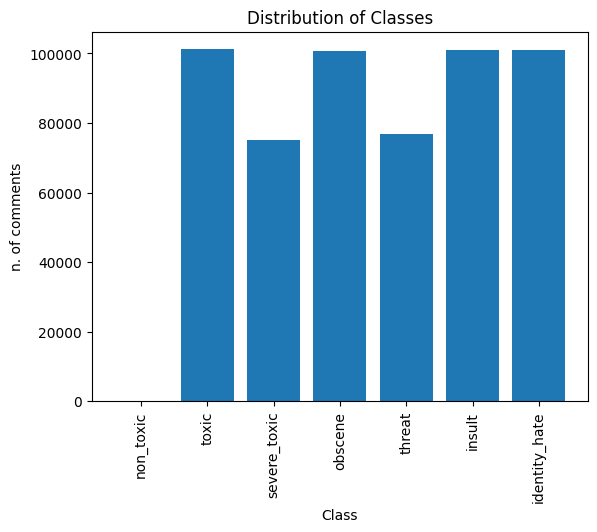

In [ ]:
x_res.shape
y_res.shape
plot_class_distribution(y_res)

In [ ]:
# reverse some token from x_res to see syntetics comments
sequences_to_text(x_res[121])
y_res[121]
print('='*100)
sequences_to_text(x_res[234])
y_res[234]
print('='*100)
sequences_to_text(x_res[345])
y_res[345]
print('='*100)
sequences_to_text(x_res[456])
y_res[456]

'hey gay wad life'

array([1, 0, 0, 0, 0, 1])

'hot rape'

array([1, 1, 1, 1, 1, 0])

'gon na beat bloodi pulp shoot execut style gon na beat bloodi pulp shoot execut style'

array([1, 0, 0, 1, 0, 0])

'littl queer jew bag'

array([1, 0, 1, 0, 1, 1])

class=0, n=111961
class=1, n=113382
class=2, n=76316
class=3, n=107468
class=4, n=77116
class=5, n=107177
class=6, n=102064


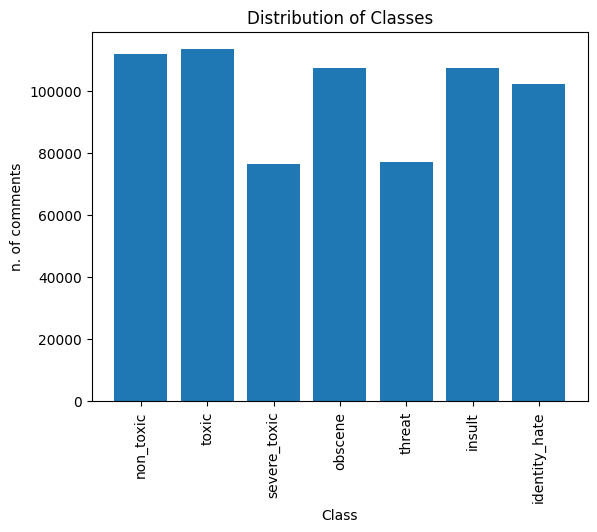

In [ ]:
x_train_oversampled = np.concatenate((x_train, x_res), axis=0)
y_train_oversampled = np.concatenate((y_train, y_res), axis=0)
plot_class_distribution(y_train_oversampled)

In [ ]:
# Calculate class distribution
over_class_distribution = np.sum(y_train_oversampled, axis=0) / len(y_train_oversampled)

# Compute inverse class weights
over_inverse_class_weights = {i: 1.0 / over_class_distribution[i] for i in range(len(over_class_distribution))}
over_inverse_class_weights

{0: 1.9947875324125524,
 1: 2.9636380313433617,
 2: 2.1045613577995312,
 3: 2.9328933035945846,
 4: 2.11027552553253,
 5: 2.2159919266342687}

In [ ]:
x_train_oversampled.shape
y_train_oversampled.shape

(226173, 145)

(226173, 6)

### Oversampled model

In [ ]:
l2_reg = 0.01  # Regularization strength

clear_session()
oversampled_model = Sequential()
oversampled_model.add(Embedding(INPUT_SIZE, 50, input_length=MAX_LEN))
oversampled_model.add(Bidirectional(LSTM(32, activation = "tanh", kernel_regularizer=l2(l2_reg))))
oversampled_model.add(Dropout(.3))
oversampled_model.add(Dense(128, activation = 'relu', kernel_regularizer=l2(l2_reg)))
oversampled_model.add(Dropout(.5))
oversampled_model.add(Dense(6,  activation = "sigmoid"))
oversampled_model.summary()

es = EarlyStopping('val_f1_score', patience= 60, verbose = 1, mode='max', restore_best_weights=True)

oversampled_model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics =['accuracy',
                        tfa.metrics.F1Score(num_classes=6, average = 'weighted')])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 145, 50)           500000    
                                                                 
 bidirectional (Bidirection  (None, 64)                21248     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 6)                 774       
                                                        

In [ ]:
history_over = oversampled_model.fit(x_train_oversampled, y_train_oversampled, validation_split=.2,
                       epochs=400, batch_size=128, class_weight = over_inverse_class_weights ,callbacks=[es])

Epoch 1/400
1414/1414 [==============================] - 131s 85ms/step - loss: 1.0800 - accuracy: 0.7547 - f1_score: 0.1551 - val_loss: 0.8874 - val_accuracy: 1.0000 - val_f1_score: 0.1814
Epoch 2/400
1414/1414 [==============================] - 40s 28ms/step - loss: 0.8457 - accuracy: 0.9618 - f1_score: 0.1160 - val_loss: 0.7334 - val_accuracy: 1.0000 - val_f1_score: 0.1814
Epoch 3/400
1414/1414 [==============================] - 32s 23ms/step - loss: 0.8264 - accuracy: 0.9893 - f1_score: 0.1131 - val_loss: 0.8286 - val_accuracy: 1.0000 - val_f1_score: 0.1814
Epoch 4/400
1414/1414 [==============================] - 29s 21ms/step - loss: 0.7811 - accuracy: 0.9751 - f1_score: 0.1171 - val_loss: 0.7704 - val_accuracy: 0.9886 - val_f1_score: 0.1844
Epoch 5/400
1414/1414 [==============================] - 30s 22ms/step - loss: 0.7623 - accuracy: 0.9545 - f1_score: 0.1230 - val_loss: 0.6591 - val_accuracy: 0.9740 - val_f1_score: 0.1882
Epoch 6/400
1414/1414 [==============================]

KeyboardInterrupt: 

In [ ]:
#plot_learning_curve(history_over.history)
y_pred_train = oversampled_model.predict(x_train).round()
print(classification_report(y_train, y_pred_train, target_names = LABELS))
print('='*60)
y_pred_test = oversampled_model.predict(x_test).round()
print(classification_report(y_test, y_pred_test, target_names = LABELS))

3903/3903 [==============================] - 35s 9ms/step
               precision    recall  f1-score   support

        toxic       0.86      0.79      0.82     12187
 severe_toxic       0.35      0.33      0.34      1256
      obscene       0.76      0.87      0.81      6735
       threat       0.12      0.13      0.12       365
       insult       0.68      0.81      0.74      6265
identity_hate       0.31      0.56      0.40      1113

    micro avg       0.72      0.77      0.75     27921
    macro avg       0.51      0.58      0.54     27921
 weighted avg       0.74      0.77      0.75     27921
  samples avg       0.07      0.07      0.07     27921

976/976 [==============================] - 6s 6ms/step
               precision    recall  f1-score   support

        toxic       0.38      0.75      0.50      3003
 severe_toxic       0.03      0.25      0.05       331
      obscene       0.27      0.81      0.41      1663
       threat       0.00      0.10      0.01       103
   

In [ ]:
oversampled_model.save('oversampled.keras')
shutil.copy("/content/oversampled.keras","/content/drive/MyDrive/Colab Notebooks")

'/content/drive/MyDrive/Colab Notebooks/oversampled.keras'

In [ ]:
#upload model frome saved .keras file
from keras.models import load_model
oversampled_model = load_model('/content/drive/MyDrive/Copia di oversampled.keras')

# Models evaluations

## Threshold tuning
Aftere I've read this article from Machine Learnin Mastery (https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/) I've decided to implement a threhold tuning to looking for the best threshold compared to its F1Score and ROC-AUC.

In [ ]:
#upload model frome saved .keras file
from keras.models import load_model
simple_model = load_model('/content/drive/MyDrive/Colab Notebooks/ProfAI/Toxic comment Project/simple.keras')

In [ ]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc


def roc_pr(y_true, y_scores):

  precision_list = []
  recall_list = []
  best_threshold = []
  best_f1_score = []
  max_idx_list = []

  n_class = y_true.shape[1]
  for i in range(n_class):
    precision, recall, thresholds = precision_recall_curve(y_true[:, i], y_scores[:, i])
    precision_list.append(precision)
    recall_list.append(recall)
    f1_scores = 2 * (precision * recall) / (precision + recall)


    max_idx = np.argmax(f1_scores)
    max_idx_list.append(max_idx)
    best_threshold.append(thresholds[max_idx])
    best_f1_score.append(f1_scores[max_idx])

  # Plotting the precision-recall curve
  no_skill = len(y_true[y_true==1])/len(y_true)
  fig, axes = plt.subplots(3,2, figsize=(30,10))
  axes_flat = axes.flatten()
  for i in range(n_class):
    ax = axes_flat[i]
    ax.plot([0,1], [no_skill, no_skill], linestyle='--', label='No Skill')
    ax.plot(recall_list[i], precision_list[i],label='LSTM')
    ax.scatter(recall_list[i][max_idx_list[i]], precision_list[i][max_idx_list[i]], marker='o',
                color='black', label = 'Optimal threshold')
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.title.set_text(f'Precision-Recall Curve: {LABELS[i]}')
    ax.legend()

  return best_threshold, best_f1_score, fig






def roc_auc(y_true, y_scores):
  """
  This fuction calculate the optimal treshold for ROC-AUC curve
  Input -> y_true, y_pred
  Output -> list of optimal threshold with its AUC score and ROC curve
  """
  fpr_list= []
  tpr_list = []
  best_threshold_roc= []
  auc_list = []
  max_idx_list = []

  n_class = y_true.shape[1]
  for i in range(n_class):
    fpr, tpr, thresholds = roc_curve(y_true[:, i], y_scores[:, i])
    roc_auc = auc(fpr, tpr)
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    auc_list.append(roc_auc)


    J = tpr-fpr
    max_idx = np.argmax(J)
    max_idx_list.append(max_idx)
    best_threshold_roc.append(thresholds[max_idx])


  fig, axes = plt.subplots(3,2, figsize=(30,10))
  axes_flat = axes.flatten()
  for i in range(n_class):
    ax = axes_flat[i]
    ax.plot(fpr_list[i], tpr_list[i], label = 'LSTM')
    ax.plot((0,1),(0,1), ls= '--',label='No Skill')
    ax.scatter(fpr_list[i][max_idx_list[i]], tpr_list[i][max_idx_list[i]], marker='o',
                label = 'Optimal Threshold')
    ax.set_xlabel('FPR')
    ax.set_ylabel('TPR')
    ax.title.set_text(f'ROC Curve: {LABELS[i]}')
    ax.legend()

  return best_threshold_roc, auc_list, fig

### Unbalaced models

3903/3903 [==============================] - 33s 8ms/step
Class toxic: Best Treshold = 0.1, AUC-ROC = 0.99
Class severe_toxic: Best Treshold = 0.007, AUC-ROC = 0.99
Class obscene: Best Treshold = 0.2, AUC-ROC = 1.0
Class threat: Best Treshold = 0.003, AUC-ROC = 0.99
Class insult: Best Treshold = 0.08, AUC-ROC = 0.99
Class identity_hate: Best Treshold = 0.006, AUC-ROC = 0.99


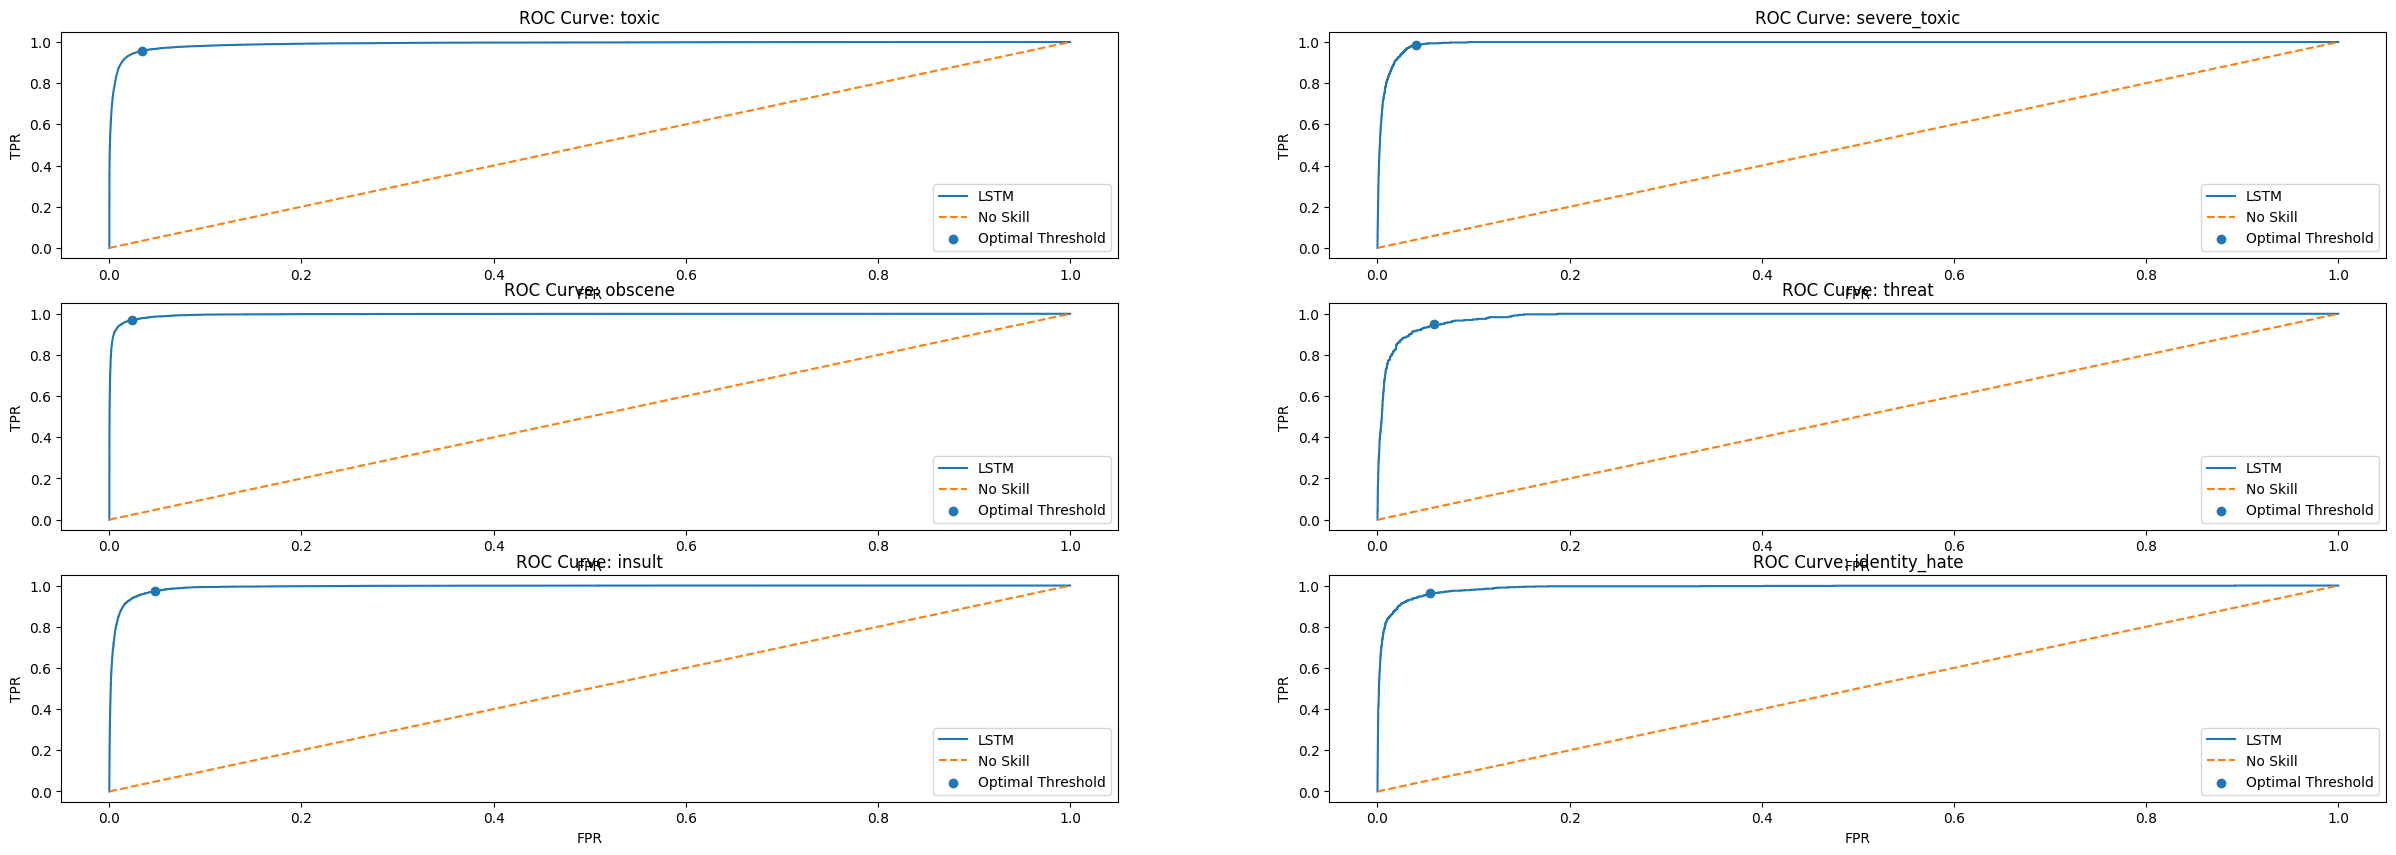

Class toxic: Best Treshold = 0.4, F1 Score = 0.89
Class severe_toxic: Best Treshold = 0.2, F1 Score = 0.63
Class obscene: Best Treshold = 0.7, F1 Score = 0.91
Class threat: Best Treshold = 0.3, F1 Score = 0.36
Class insult: Best Treshold = 0.5, F1 Score = 0.84
Class identity_hate: Best Treshold = 0.3, F1 Score = 0.66


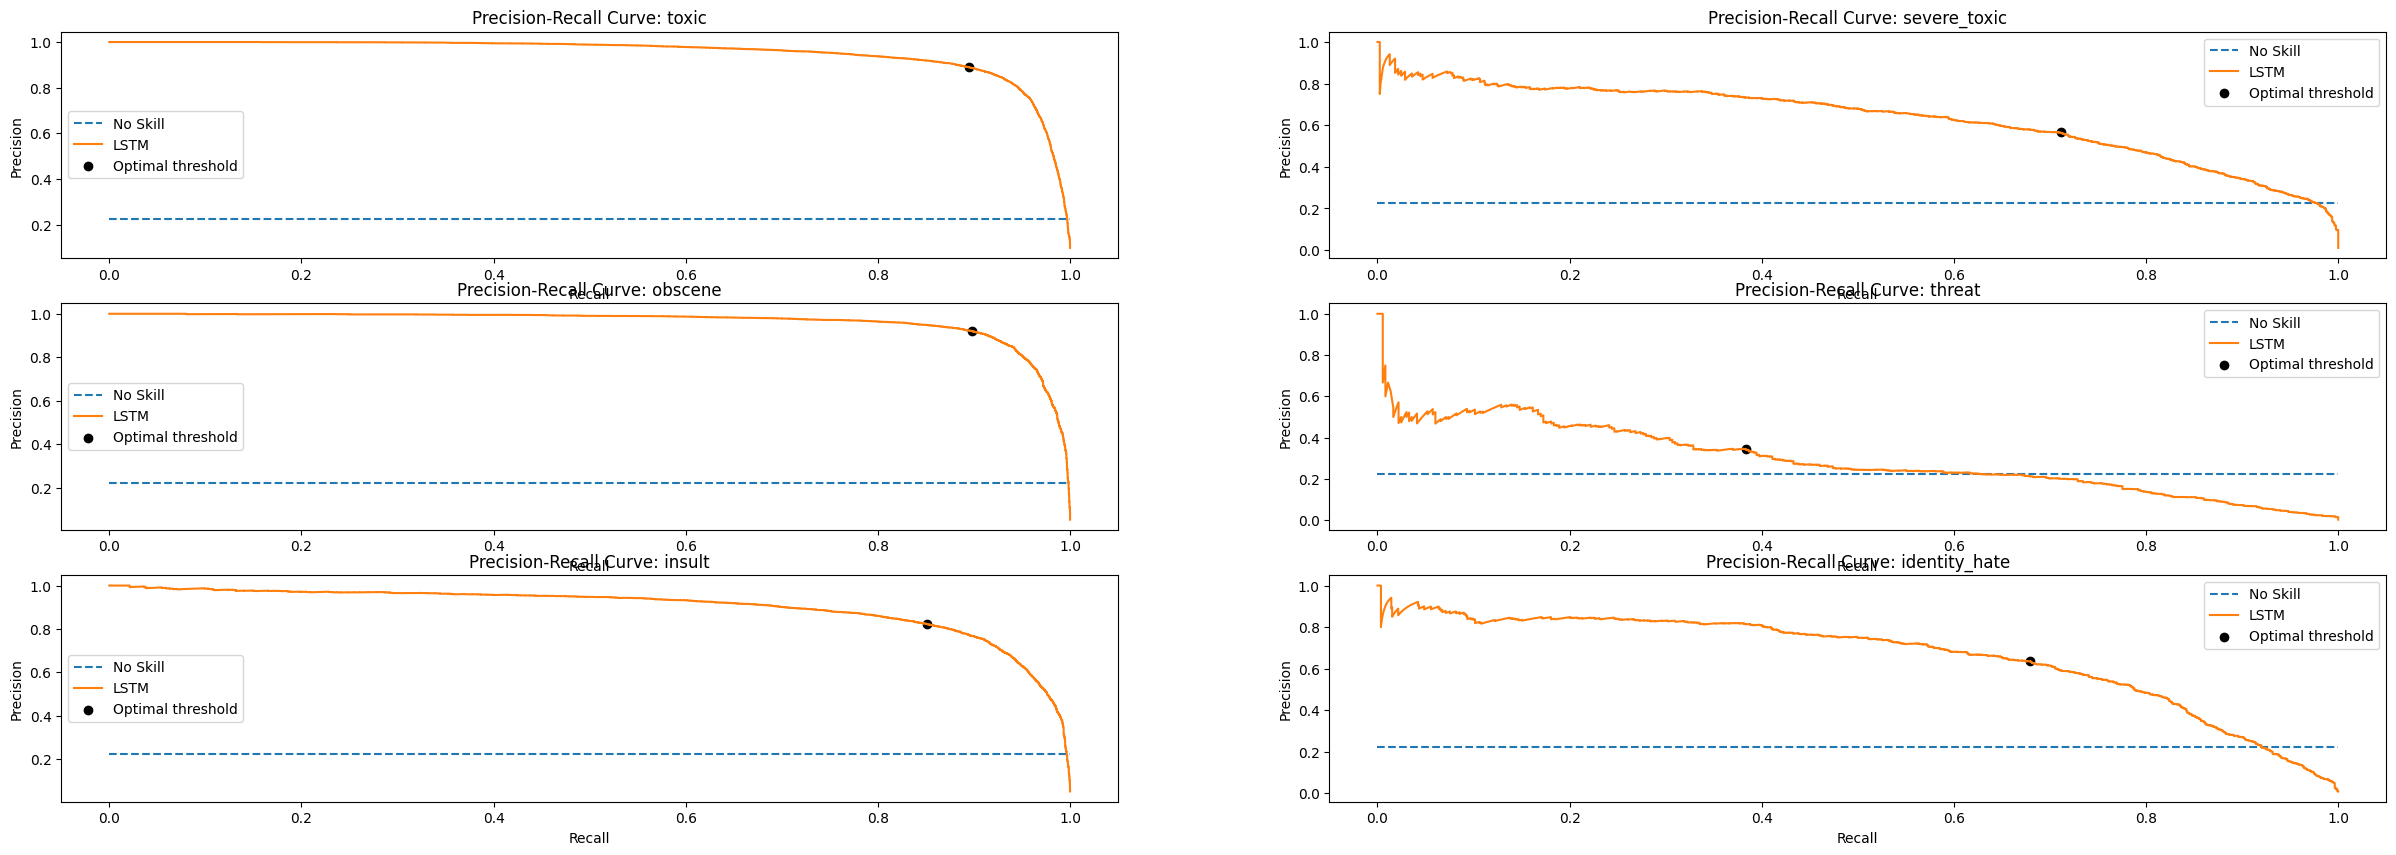

In [ ]:
y_train_pred_1 = simple_model.predict(x_train)
threshold_roc_auc1, auc1, fig = roc_auc(y_train, y_train_pred_1)
for i, (thresh, auc) in enumerate(zip(threshold_roc_auc1, auc1)):
    print(f"Class {LABELS[i]}: Best Treshold = {thresh:.0}, AUC-ROC = {auc:.2}")
plt.show()
print('='*100)
threshold_roc_pr1, best_f1_score1, fig = roc_pr(y_train, y_train_pred_1)
for i, (thresh, f1_score) in enumerate(zip(threshold_roc_pr1, best_f1_score1)):
    print(f"Class {LABELS[i]}: Best Treshold = {thresh:.0}, F1 Score = {f1_score:.2}")
plt.show()

In [ ]:
simple_model2 = load_model('/content/drive/MyDrive/Colab Notebooks/ProfAI/Toxic comment Project/simple2.keras')

Class toxic: Best Treshold = 0.1, AUC-ROC = 0.99
Class severe_toxic: Best Treshold = 0.02, AUC-ROC = 0.99
Class obscene: Best Treshold = 0.06, AUC-ROC = 0.99
Class threat: Best Treshold = 0.01, AUC-ROC = 0.98
Class insult: Best Treshold = 0.07, AUC-ROC = 0.99
Class identity_hate: Best Treshold = 0.02, AUC-ROC = 0.99


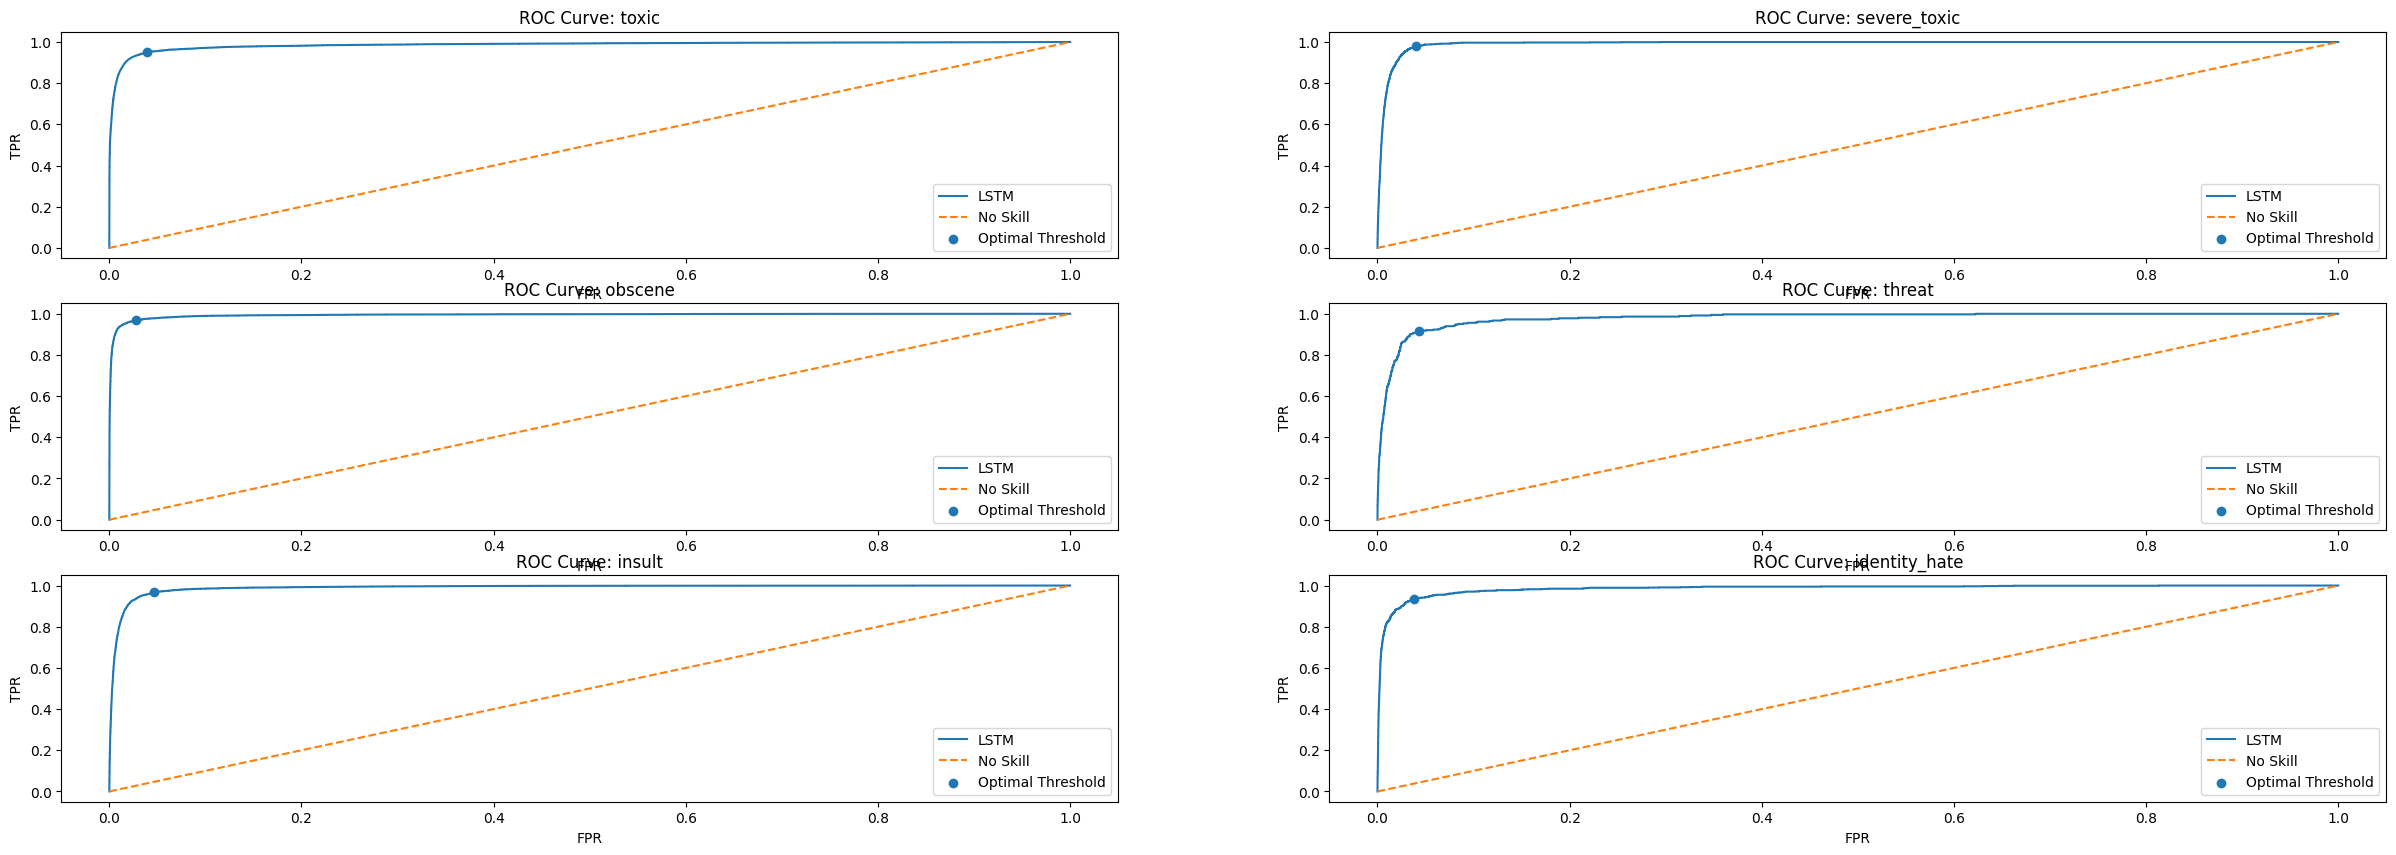

Class toxic: Best Treshold = 0.4, F1 Score = 0.88
Class severe_toxic: Best Treshold = 0.3, F1 Score = 0.57
Class obscene: Best Treshold = 0.5, F1 Score = 0.9
Class threat: Best Treshold = 0.4, F1 Score = 0.32
Class insult: Best Treshold = 0.5, F1 Score = 0.81
Class identity_hate: Best Treshold = 0.3, F1 Score = 0.65


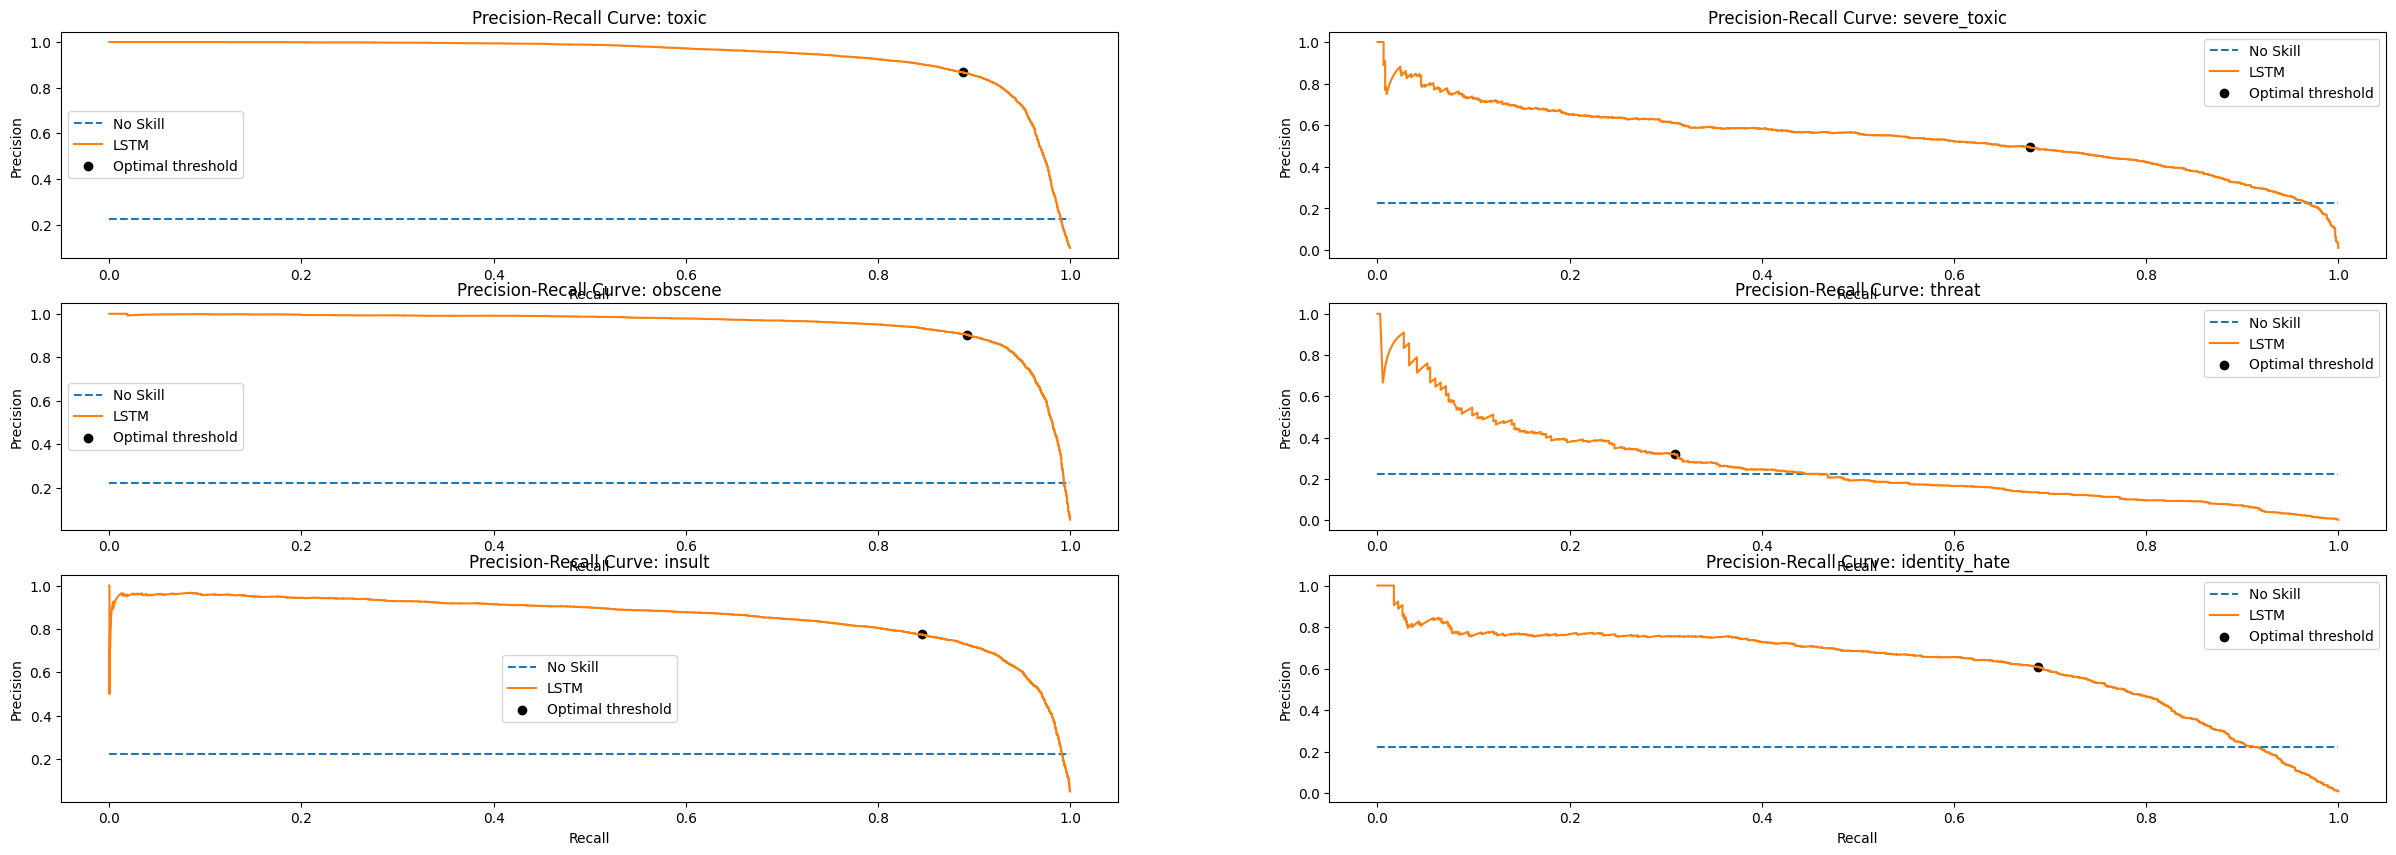

In [ ]:
y_train_pred_2 = simple_model2.predict(x_train)
threshold_roc_auc2, auc2, fig = roc_auc(y_train, y_train_pred_2)
for i, (thresh, auc) in enumerate(zip(threshold_roc_auc2, auc2)):
    print(f"Class {LABELS[i]}: Best Treshold = {thresh:.0}, AUC-ROC = {auc:.2}")
plt.show()
print('='*100)
threshold_roc_pr2, best_f1_score2, fig = roc_pr(y_train, y_train_pred_2)
for i, (thresh, f1_score) in enumerate(zip(threshold_roc_pr2, best_f1_score2)):
    print(f"Class {LABELS[i]}: Best Treshold = {thresh:.0}, F1 Score = {f1_score:.2}")
plt.show()

3903/3903 [==============================] - 22s 6ms/step
Class toxic: Best Treshold = 0.05, AUC-ROC = 0.96
Class severe_toxic: Best Treshold = 0.01, AUC-ROC = 0.99
Class obscene: Best Treshold = 0.05, AUC-ROC = 0.97
Class threat: Best Treshold = 0.1, AUC-ROC = 0.95
Class insult: Best Treshold = 0.07, AUC-ROC = 0.97
Class identity_hate: Best Treshold = 0.03, AUC-ROC = 0.95


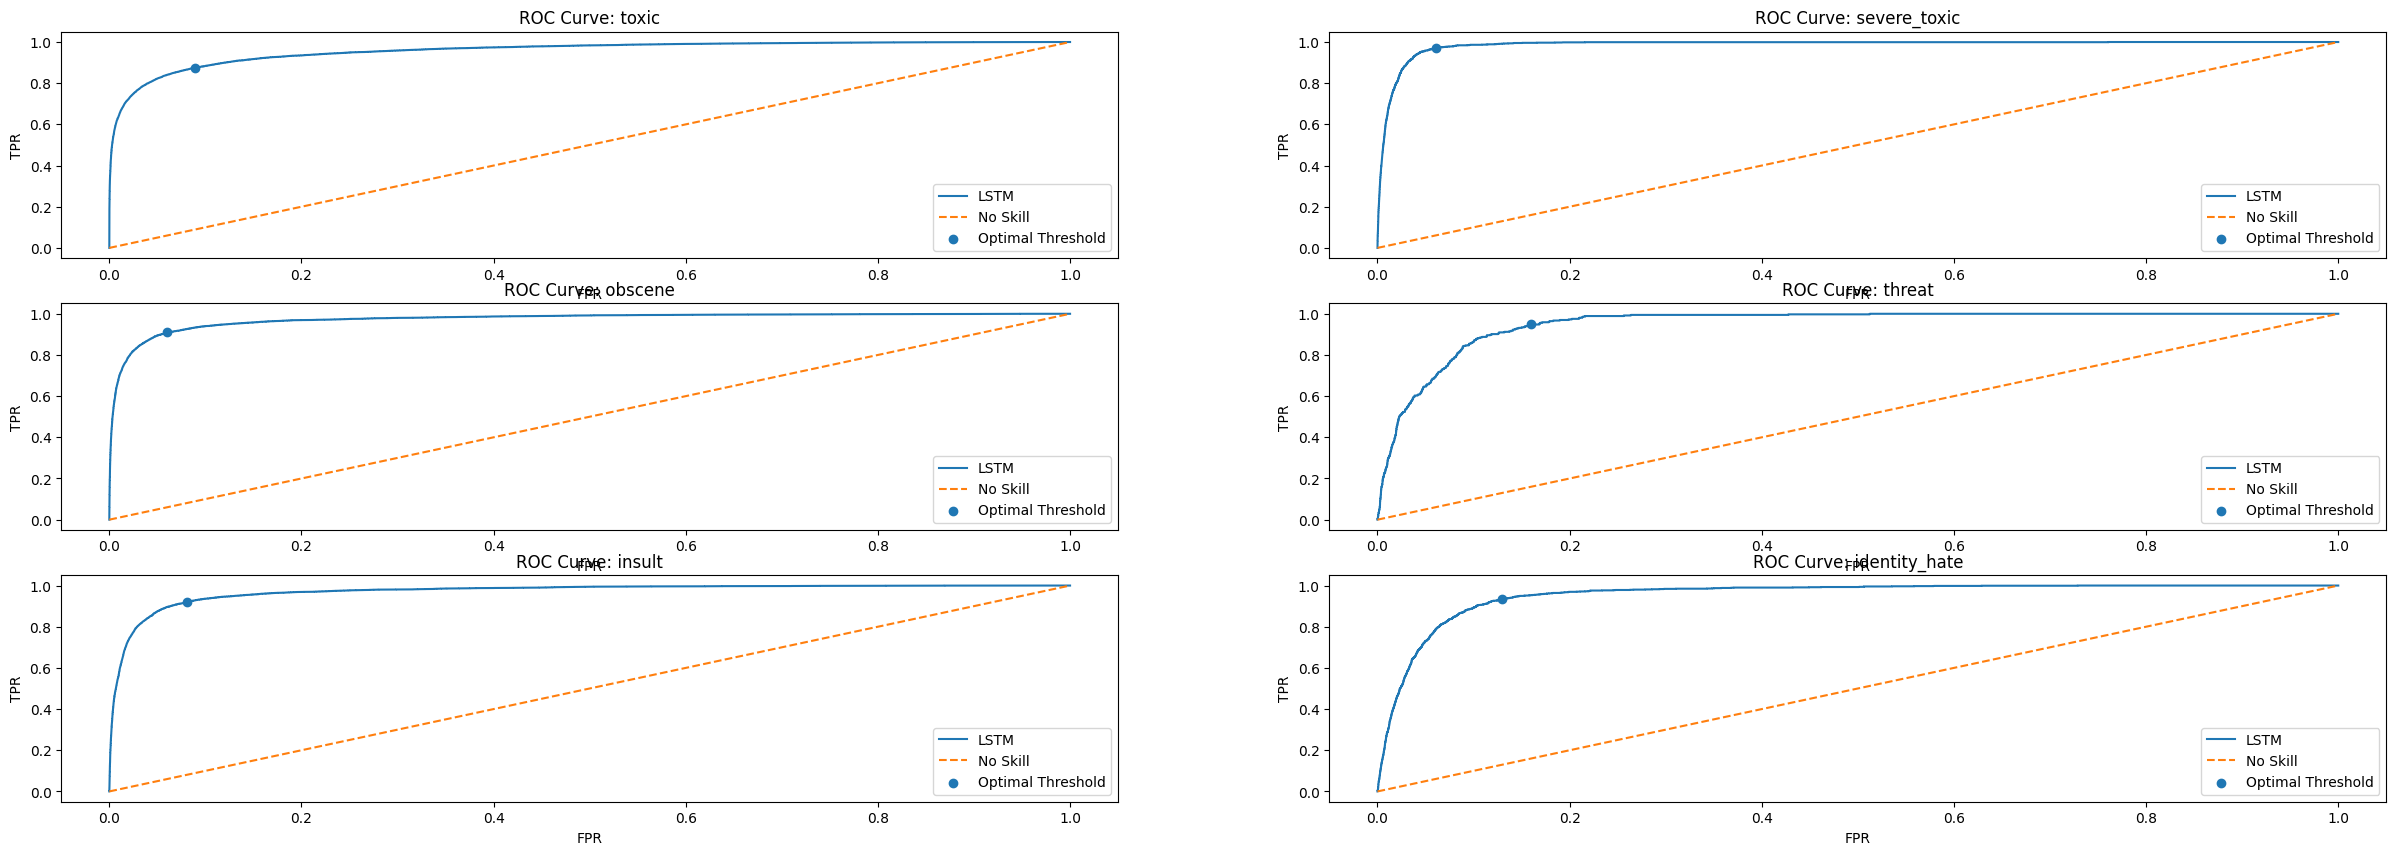

Class toxic: Best Treshold = 0.2, F1 Score = 0.76
Class severe_toxic: Best Treshold = 0.2, F1 Score = 0.49
Class obscene: Best Treshold = 0.2, F1 Score = 0.75
Class threat: Best Treshold = 0.4, F1 Score = nan
Class insult: Best Treshold = 1e+00, F1 Score = nan
Class identity_hate: Best Treshold = 0.3, F1 Score = nan


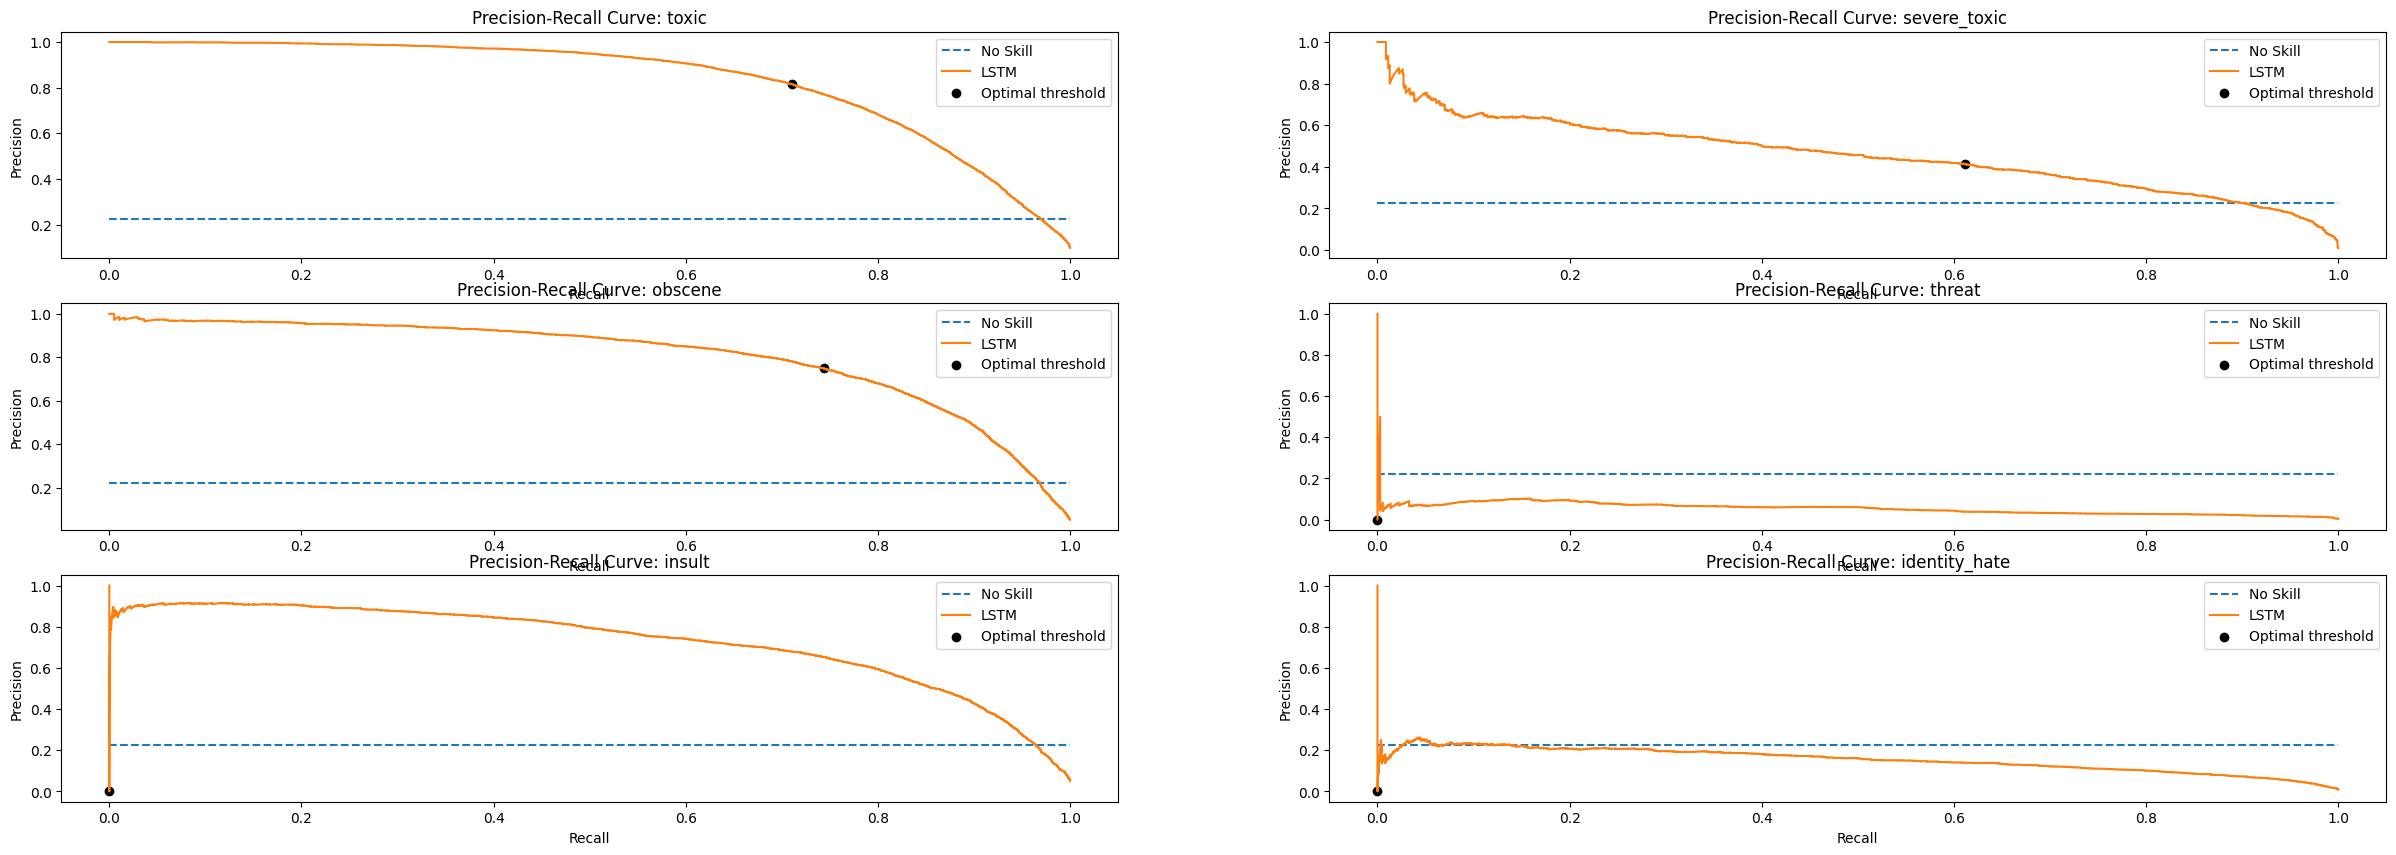

In [ ]:
y_train_pred_3 = simple_model3.predict(x_train)
threshold_roc_auc3, auc3, fig = roc_auc(y_train, y_train_pred_3)
for i, (thresh, auc) in enumerate(zip(threshold_roc_auc3, auc3)):
    print(f"Class {LABELS[i]}: Best Treshold = {thresh:.0}, AUC-ROC = {auc:.2}")
plt.show()
print('='*200)
threshold_roc_pr3, best_f1_score3, fig = roc_pr(y_train, y_train_pred_3)
for i, (thresh, f1_score) in enumerate(zip(threshold_roc_pr3, best_f1_score3)):
    print(f"Class {LABELS[i]}: Best Treshold = {thresh:.0}, F1 Score = {f1_score:.2}")
plt.show()

### Oversampled

In [ ]:
oversampled_model = load_model('/content/drive/MyDrive/Colab Notebooks/ProfAI/Toxic comment Project/oversampled.keras')

3903/3903 [==============================] - 26s 6ms/step
Class toxic: Best Treshold = 0.2, AUC-ROC = 1.0
Class severe_toxic: Best Treshold = 0.4, AUC-ROC = 1.0
Class obscene: Best Treshold = 0.2, AUC-ROC = 1.0
Class threat: Best Treshold = 0.4, AUC-ROC = 1.0
Class insult: Best Treshold = 0.07, AUC-ROC = 1.0
Class identity_hate: Best Treshold = 0.2, AUC-ROC = 1.0


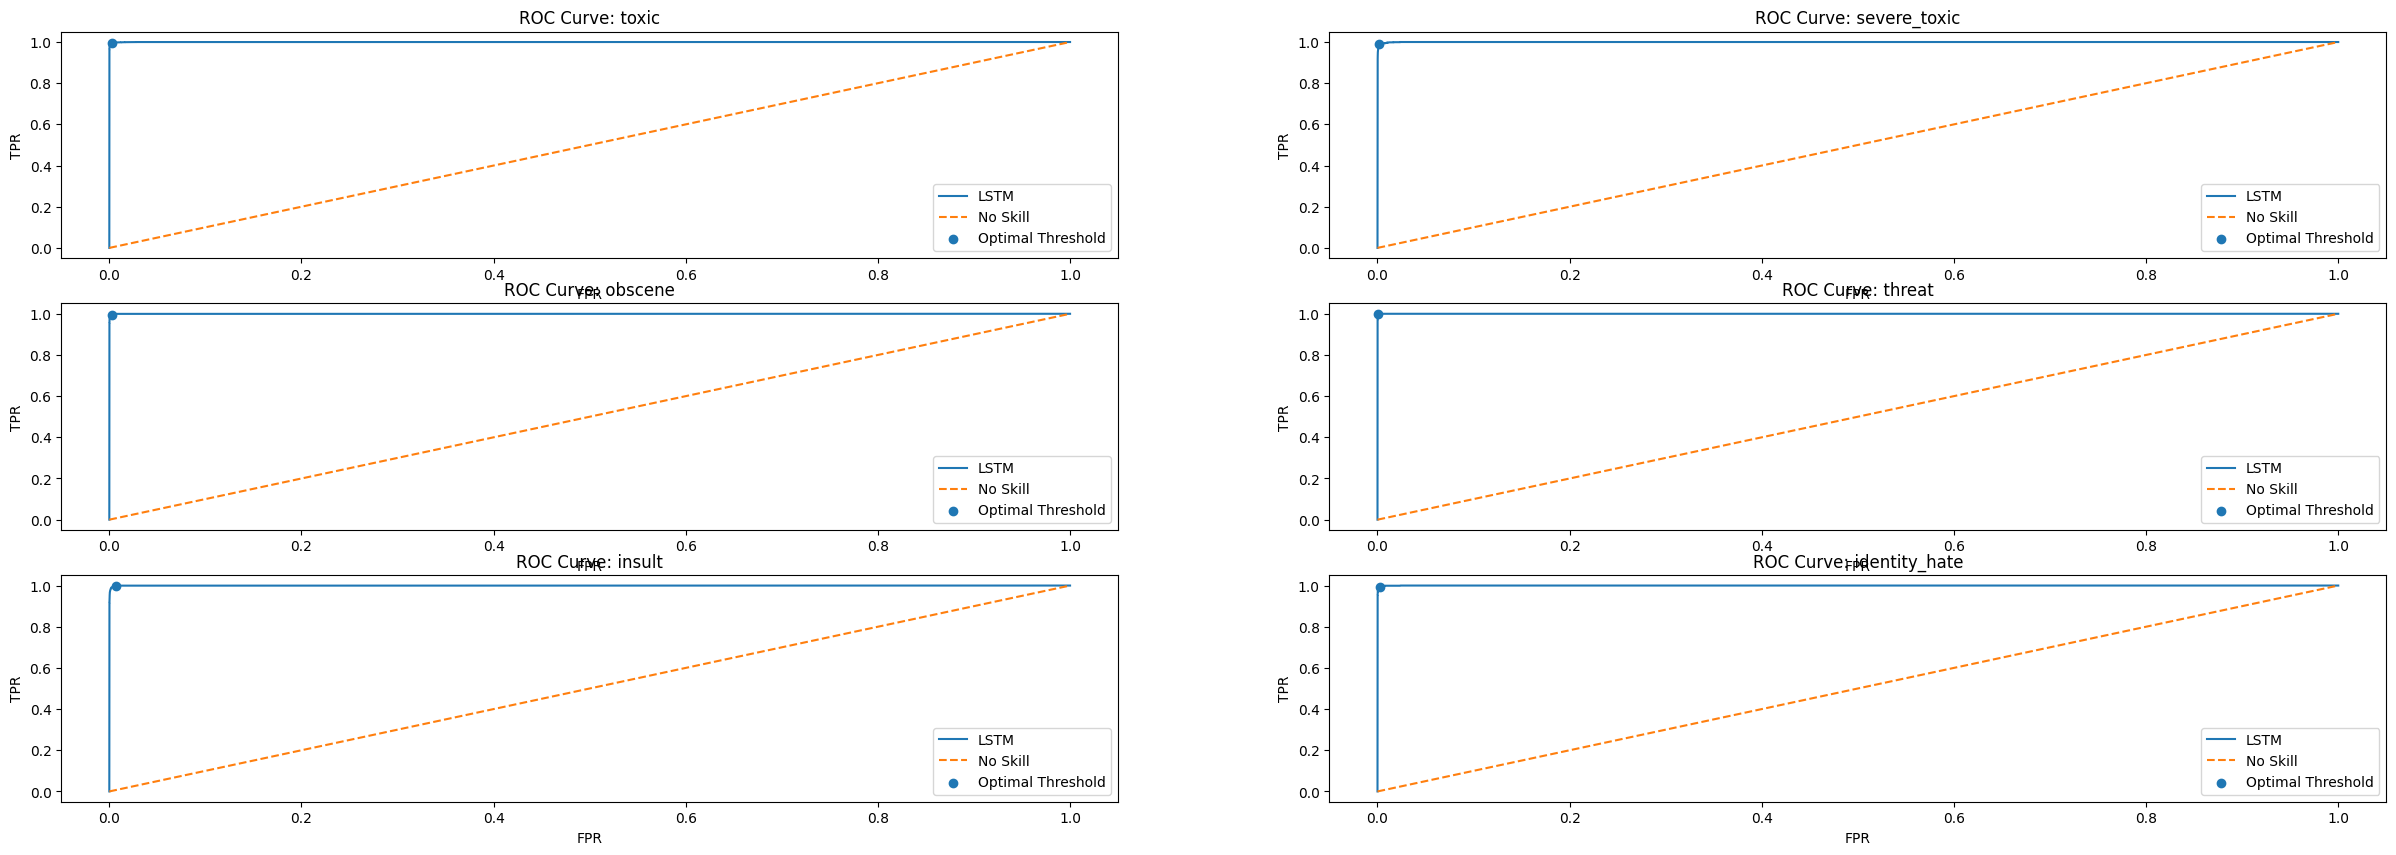

Class toxic: Best Treshold = 0.6, F1 Score = 0.99
Class severe_toxic: Best Treshold = 0.9, F1 Score = 0.96
Class obscene: Best Treshold = 0.6, F1 Score = 0.99
Class threat: Best Treshold = 0.9, F1 Score = 0.97
Class insult: Best Treshold = 0.6, F1 Score = 0.98
Class identity_hate: Best Treshold = 0.8, F1 Score = 0.97


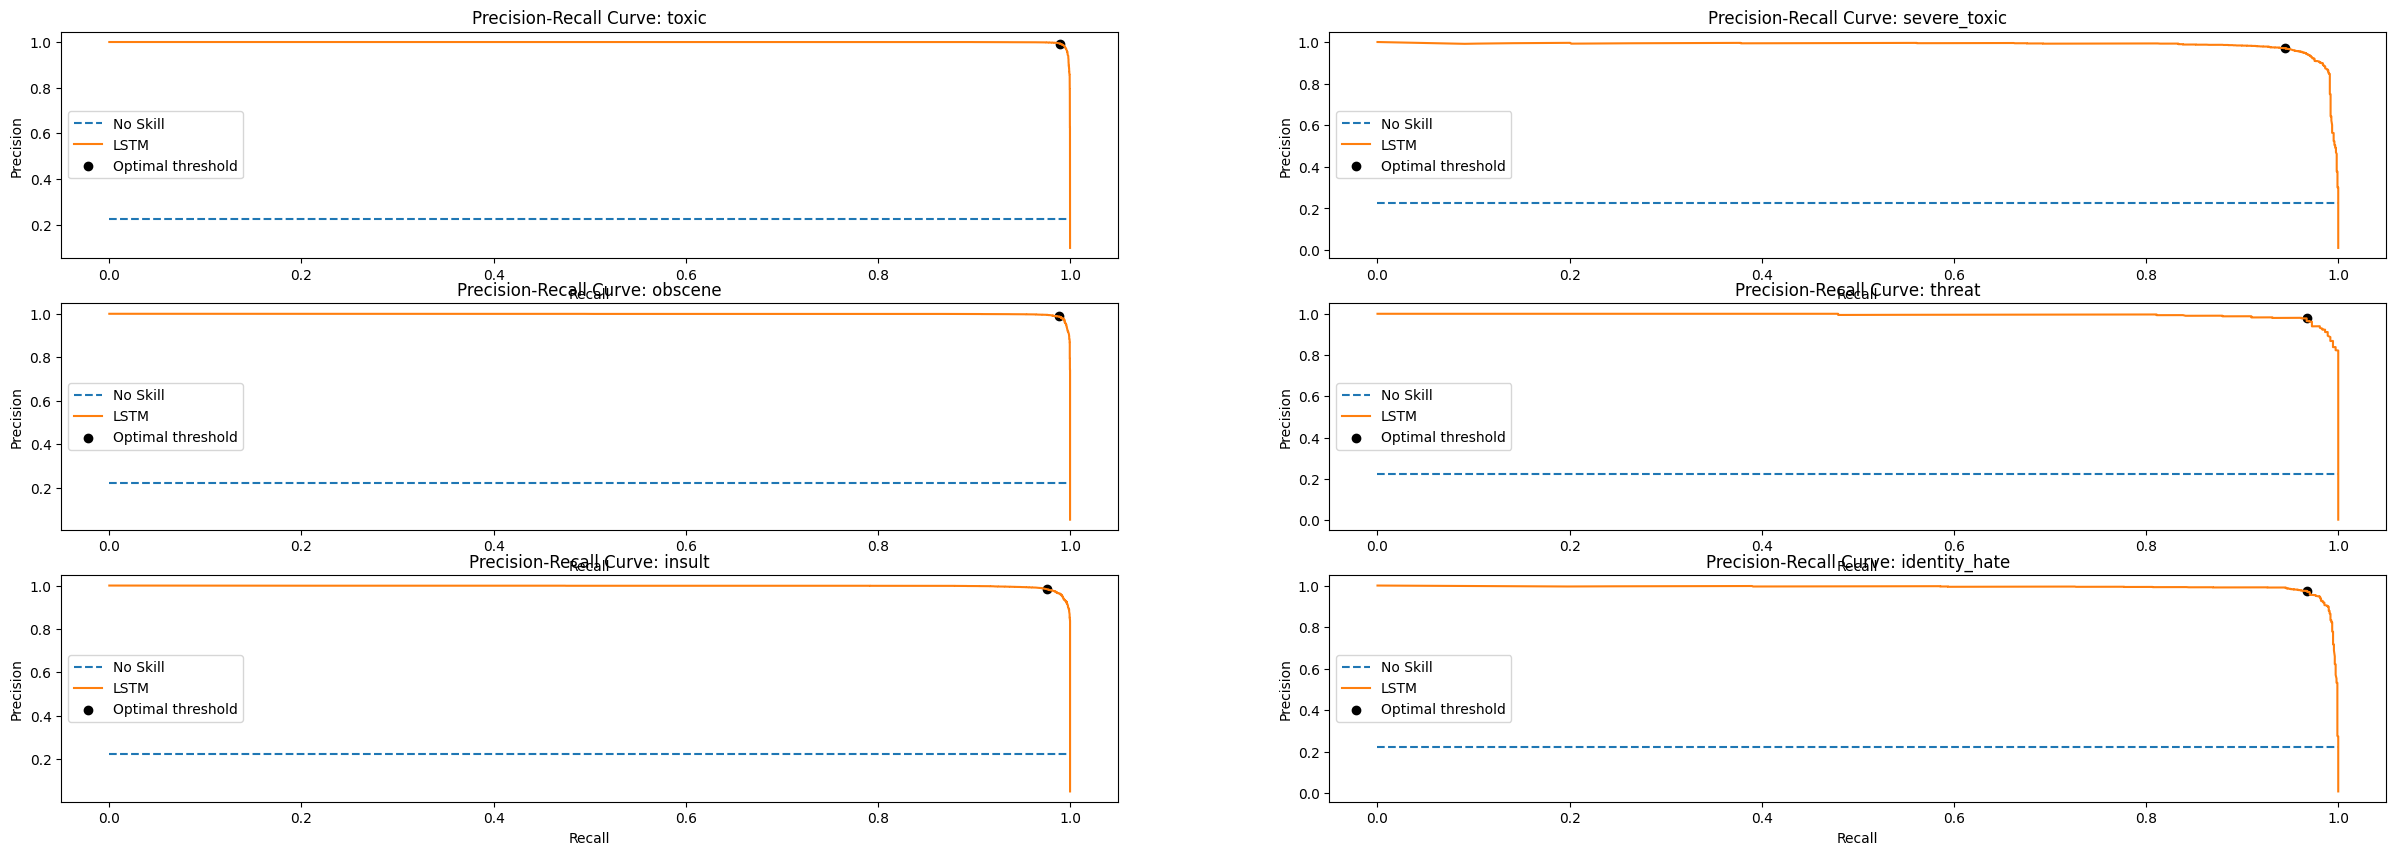

In [ ]:
y_train_pred_over = oversampled_model.predict(x_train)
threshold_roc_auc4, auc4, fig = roc_auc(y_train, y_train_pred_over)
for i, (thresh, auc) in enumerate(zip(threshold_roc_auc4, auc4)):
    print(f"Class {LABELS[i]}: Best Treshold = {thresh:.0}, AUC-ROC = {auc:.2}")
plt.show()
print('='*200)
threshold_roc_pr4, best_f1_score4, fig = roc_pr(y_train, y_train_pred_over)
for i, (thresh, f1_score) in enumerate(zip(threshold_roc_pr4, best_f1_score4)):
    print(f"Class {LABELS[i]}: Best Treshold = {thresh:.0}, F1 Score = {f1_score:.2}")
plt.show()

# Prediction time

In [ ]:
def print_result(y_pred, treshold):
  values = []
  for i in range(len(y_pred)):
    y_pred_val = int(y_pred[i] > treshold[i])
    values.append(y_pred_val)

  return values



## Base model

In [ ]:
print(f'y_true: {y_test[132]}')
print('='*20)
# 0.5 threshold
print('0.5 Threshold:')
_ = print_result(basemodel_y_pred_test[132], [.5,.5,.5,.5,.5,.5])
for i,v in enumerate(_):
  print(f'{LABELS[i]}: {v}')

y_true: [1 0 1 0 1 1]
0.5 Threshold:
toxic: 1
severe_toxic: 0
obscene: 0
threat: 0
insult: 0
identity_hate: 0


In [ ]:
y_test_pred_1 = simple_model.predict(x_test)

print(f'Text: {sequences_to_text(x_test[132])}')
print(f'y_true: {y_test[132]}')
print('='*20)

# 0.5 threshold
print('0.5 Threshold:')
_ = print_result(y_test_pred_1[132], [.5,.5,.5,.5,.5,.5])
for i,v in enumerate(_):
  print(f'{LABELS[i]}: {v}')
print('='*20)

# threshold tuned ROC-AUC
print('Threshold tuned:')
_ = print_result(y_test_pred_1[132], threshold_roc_auc1)
for i,v in enumerate(_):
  print(f'{LABELS[i]}: {v}')
print('='*20)

# threshold tuned AUC-PR
print('Threshold tuned:')
_ = print_result(y_test_pred_1[132], threshold_roc_pr1)
for i,v in enumerate(_):
  print(f'{LABELS[i]}: {v}')

976/976 [==============================] - 10s 10ms/step
Text: masturb custard heard poplular white peopl white boy comfim
y_true: [1 0 1 0 1 1]
0.5 Threshold:
toxic: 1
severe_toxic: 0
obscene: 0
threat: 0
insult: 0
identity_hate: 0
Threshold tuned:
toxic: 1
severe_toxic: 0
obscene: 0
threat: 1
insult: 1
identity_hate: 1
Threshold tuned:
toxic: 1
severe_toxic: 0
obscene: 0
threat: 0
insult: 0
identity_hate: 0


In [ ]:
# I print classification report with best tuned treshold
y_test_pred_1_tuned = (y_test_pred_1 >= threshold_roc_auc1).astype(int)
print(classification_report(y_test, y_test_pred_1_tuned, target_names = LABELS))


               precision    recall  f1-score   support

        toxic       0.59      0.87      0.71      3003
 severe_toxic       0.21      0.94      0.35       331
      obscene       0.65      0.92      0.76      1663
       threat       0.04      0.75      0.07       103
       insult       0.47      0.91      0.62      1569
identity_hate       0.12      0.87      0.21       280

    micro avg       0.40      0.89      0.56      6949
    macro avg       0.35      0.88      0.45      6949
 weighted avg       0.53      0.89      0.65      6949
  samples avg       0.05      0.09      0.06      6949



In [ ]:
y_test_pred_2 = simple_model2.predict(x_test)

print(f'Text: {sequences_to_text(x_test[132])}')
print(f'y_true: {y_test[132]}')
print('='*20)

# 0.5 threshold
print('0.5 Threshold:')
_ = print_result(y_test_pred_2[132], [.5,.5,.5,.5,.5,.5])
for i,v in enumerate(_):
  print(f'{LABELS[i]}: {v}')
print('='*20)

# threshold tuned ROC-AUC
print('Threshold tuned ROC-AUC:')
_ = print_result(y_test_pred_2[132], threshold_roc_auc2)
for i,v in enumerate(_):
  print(f'{LABELS[i]}: {v}')
print('='*20)

# threshold tuned AUC-PR
print('Threshold tuned AUC-PR:')
_ = print_result(y_test_pred_2[132], threshold_roc_pr2)
for i,v in enumerate(_):
  print(f'{LABELS[i]}: {v}')

976/976 [==============================] - 8s 9ms/step
Text: masturb custard heard poplular white peopl white boy comfim
y_true: [1 0 1 0 1 1]
0.5 Threshold:
toxic: 1
severe_toxic: 0
obscene: 0
threat: 0
insult: 0
identity_hate: 0
Threshold tuned ROC-AUC:
toxic: 1
severe_toxic: 0
obscene: 1
threat: 0
insult: 1
identity_hate: 0
Threshold tuned AUC-PR:
toxic: 1
severe_toxic: 0
obscene: 0
threat: 0
insult: 0
identity_hate: 0


In [ ]:
# I print classification report with best tuned treshold
y_test_pred_2_tuned = (y_test_pred_2 >= threshold_roc_auc2).astype(int)
print(classification_report(y_test, y_test_pred_2_tuned, target_names = LABELS))


               precision    recall  f1-score   support

        toxic       0.60      0.84      0.70      3003
 severe_toxic       0.20      0.92      0.33       331
      obscene       0.58      0.89      0.70      1663
       threat       0.04      0.63      0.08       103
       insult       0.46      0.85      0.60      1569
identity_hate       0.13      0.73      0.23       280

    micro avg       0.42      0.85      0.56      6949
    macro avg       0.34      0.81      0.44      6949
 weighted avg       0.52      0.85      0.63      6949
  samples avg       0.05      0.08      0.06      6949



In [ ]:
y_test_pred_4 = oversampled_model.predict(x_test)

print(f'Text: {sequences_to_text(x_test[132])}')
print(f'y_true: {y_test[132]}')
print('='*20)

# 0.5 threshold
print('0.5 Threshold:')
_ = print_result(y_test_pred_4[132], [.5,.5,.5,.5,.5,.5])
for i,v in enumerate(_):
  print(f'{LABELS[i]}: {v}')
print('='*20)

# threshold tuned ROC-AUC
print('Threshold tuned ROC-AUC:')
_ = print_result(y_test_pred_4[132], threshold_roc_auc4)
for i,v in enumerate(_):
  print(f'{LABELS[i]}: {v}')
print('='*20)

# threshold tuned AUC-PR
print('Threshold tuned AUC-PR:')
_ = print_result(y_test_pred_4[132], threshold_roc_pr4)
for i,v in enumerate(_):
  print(f'{LABELS[i]}: {v}')

976/976 [==============================] - 10s 11ms/step
Text: masturb custard heard poplular white peopl white boy comfim
y_true: [1 0 1 0 1 1]
0.5 Threshold:
toxic: 1
severe_toxic: 0
obscene: 0
threat: 0
insult: 0
identity_hate: 0
Threshold tuned ROC-AUC:
toxic: 1
severe_toxic: 0
obscene: 0
threat: 0
insult: 0
identity_hate: 0
Threshold tuned AUC-PR:
toxic: 1
severe_toxic: 0
obscene: 0
threat: 0
insult: 0
identity_hate: 0


In [ ]:
# I print classification report with best tuned treshold
y_test_pred_4_tuned = (y_test_pred_4 >= threshold_roc_auc4).astype(int)
print(classification_report(y_test, y_test_pred_4_tuned, target_names = LABELS))


               precision    recall  f1-score   support

        toxic       0.35      0.79      0.49      3003
 severe_toxic       0.06      0.50      0.11       331
      obscene       0.24      0.78      0.37      1663
       threat       0.01      0.37      0.03       103
       insult       0.20      0.70      0.31      1569
identity_hate       0.04      0.52      0.07       280

    micro avg       0.19      0.73      0.30      6949
    macro avg       0.15      0.61      0.23      6949
 weighted avg       0.26      0.73      0.38      6949
  samples avg       0.06      0.07      0.06      6949



# Final comment
The model still does not perform at the maximum F1Score value but I can still be satisfied with the second one I created.
As for the model created via MLSMOTE it still underperforms my second model which only uses the class_weight parameter to give more weight to the minority classes, and above all it requires much less computing power.
Finally, I believe that fine tuning the treshold can be a great tool to improve the work even more, especially that used as a metric the ROC-AUC